# Reddit Sentiment Analysis
## Michael Sanchez
### Kean University
### CPS5881
***

#### Background
For my independent study course I decided to focus my reasearch on the sentiment analysis of Reddit titles from the Reddit Gaming Subreddit. I hoped to discover possible correlations between sentiment and various factors such as upvotes, comments, and upvote ratios. Over 2000 records were collected throught the course of of a month. Using cron job, I was able to consistently collect Reddit Posts using the python library PRAW to access throught the top search function. The data was collected monday through friday, and the script was run on each day at 8:00PM. Once the data had been collected, cleaned, processed through Vader sentiment analysis, and stored onto an external MySQL database, I furthermore made use of creating a materialized view of the original reddit table data which totaled over 13,000 records collected into a unique view of all unique and recent records which totaled at 2,833 unique records.

***
#### Python

##### The following Python Libraries will be used to help conduct the analysis of the reddit data collected
- mysql.connector
- pandas
- config parser
- seaborn
- matplotlib


In [42]:
#Imports================================================

from datetime import datetime,timedelta, timezone #-- dateime convert timestamp to datetime and back
#import csv #used to write to csv
import pandas as pd  # Read and Save CSV
import csv
import os


import mysql.connector
import configparser
#from keys import *
#============================================================
#Connect to the database=====================================
#++++++++Database Implementation+++++++++++++++++
#Config parser and import dbconfig.ini
config = configparser.ConfigParser()
config.read('dbconfig.ini')
mydb = mysql.connector.connect(
  host = config.get('database','host'),
   database = config.get('database', 'database'),
   username = config.get('database', 'username'),
   password = config.get('database', 'password')
   )

#Check if DB is connected
#print(mydb.is_connected())

#============================================================
#Load the Data into an array
#Intialize a list to store out tuples
dbVal = list()
#---------------------------------------------------
#Create Headers
headers = ("cleaned_post", "pid", "author", "date_created", "upvote_ratio", "upvote_total", "comment_count", "negative", "neutral", "positive", "compound", "overall_sentiment", "date_obtained")
#Add tuple to the list
dbVal.append(headers)
#---------------------------------------------------
#SQL Cursor
mycursor = mydb.cursor()
#SQL Query
query = ("""
        SELECT * FROM  RedditDataFinal
         """)
#Items returned in query: cleaned_post, pid, author, date_created, upvote_ratio, upovte_total, comment_count, negative, neutral, positive, compound, overall_sentiment, date_obtained

#Run the Query
mycursor.execute(query)

#For loop grab all items from query and Store in an tuple and append to intial list dbVal
for (cleaned_post, pid, author, date_created, upvote_ratio, upovte_total, comment_count, negative, neutral, positive, compound, overall_sentiment, date_obtained)in mycursor:
    reddit_tuple = (cleaned_post, pid, author, date_created, upvote_ratio, upovte_total, comment_count, negative, neutral, positive, compound, overall_sentiment, date_obtained)
    dbVal.append(reddit_tuple)

#Convert to pandas dataframe
df = pd.DataFrame(dbVal)

#==========Close Connection==========================
mycursor.close()
mydb.close()
#============================================================
#print dataframe length
print(len(df.index))
#print first ten records
print(df.head(10))

2834
                                                  0        1   \
0                                       cleaned_post      pid   
1          Just Got My BRAND NEW game from GameStop!  176i70g   
2  Whats one of the biggest wastes of money in Ga...  176ad4v   
3  Valve adds new security check after attackers ...  1763wf1   
4  I just set the world record for the fastest de...  17aully   
5  I decided to play Star Wars Battlefront 2 (200...  176ixo6   
6                                       Best visuals  176fdcs   
7  MC Chris rants about Kingdom Hearts 2 and Resi...  176c2q1   
8  What game that people talk about “everyone mus...  176dzxe   
9  What went wrong with Sonic that it couldnt hol...  17aylsr   

                     2                    3             4             5   \
0                author         date_created  upvote_ratio  upvote_total   
1        brandonbluntly  2023-10-12 17:35:09           0.9         11512   
2         TheLuiginator  2023-10-12 11:58:39       

## Optional: Save/Load from CSV
### Saving
Optionally we can choose to save our data retrieved from the database into a local csv file. 
We can do this by using the to CSV function for Pandas Dataframe, `df.to_CSV()`.
Once Saved we can then view the CSV in our local repository which contains our notebook.
![Image of the CSV file we create below.](Screenshots/FinalRedditDataCSV.png)


### Loading
We can then furthermore use this CSV file to load our dataset, especially offline.
We do this by using read function from the Pandas Library, `pd.read_CSV()`. 
With this we can load back in as a pandas dataframe.

In [43]:
#Optional Save/Load from CSV
#Saving
#SaveName
savename="FinalRedditData.csv"

#File Type  #Include encoding to 'utf-8-sig' for emoji support
df.to_csv(savename, index = False, header = False, encoding='utf-8-sig')


In [44]:
#Optional Save/Load from CSV
#Loading from CSV
#We will perform this operation in a try except statement.
#NOTE: the filepath is relative to the location of where this notebook is run.
filepath ="FinalRedditData.csv"
df = pd.read_csv(filepath, header=0, encoding='utf-8-sig' , parse_dates=["date_created", "date_obtained"])


print("CSV file loaded with ",len(df.index)," records.")



CSV file loaded with  2833  records.


# Correlation
***
## Pandas
The Pandas library contains another datagrame function to find the correlation between two columns.
This method is `df.corr(method='pearson', min_periods=1, numeric_only=False)`. 
The methods that may be chosen include:
- pearson : standard correlation coefficient
- kendall : Kendall Tau correlation coefficient
- spearman : Spearman rank correlation
- callable: callable with input two 1d ndarrays and returning a float. Note that the returned matrix from corr will have along the diagonals and will be symmetric regardless of the callable’s behavior.

min_periods (int, optional)
- Minimum number of observations required per pair of columns to have a valid result. Currently only available for Pearson and Spearman correlation.
numeric_onlybool (default False)
- Include only float, int or boolean data.

This information on the corr function and more can be found from the [offical pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).
***


## Pearson Correlation
Using the Pearson correlation coeffiecent $ r $ we can measure the linear correlation of each of our numerical columns.
***

In [45]:
corr = df.corr(method = 'pearson')
corr

upvote_ratio  upvote_total  comment_count  negative   neutral  \
upvote_ratio       1.000000      0.372853       0.293335  0.060795 -0.038352   
upvote_total       0.372853      1.000000       0.479696  0.059754  0.013195   
comment_count      0.293335      0.479696       1.000000  0.060728 -0.003155   
negative           0.060795      0.059754       0.060728  1.000000 -0.513613   
neutral           -0.038352      0.013195      -0.003155 -0.513613  1.000000   
positive          -0.001975     -0.060417      -0.042357 -0.167254 -0.760031   
compound          -0.030281     -0.095005      -0.070471 -0.636373 -0.212746   

               positive  compound  
upvote_ratio  -0.001975 -0.030281  
upvote_total  -0.060417 -0.095005  
comment_count -0.042357 -0.070471  
negative      -0.167254 -0.636373  
neutral       -0.760031 -0.212746  
positive       1.000000  0.726467  
compound       0.726467  1.000000

### Applying Data Visulization
The above table is not idle for finding what columns in our data set contain significant correlation. Thus we must use a heatmap throught the seaborn library for our eyes to see. With this we may draw further conclusions.

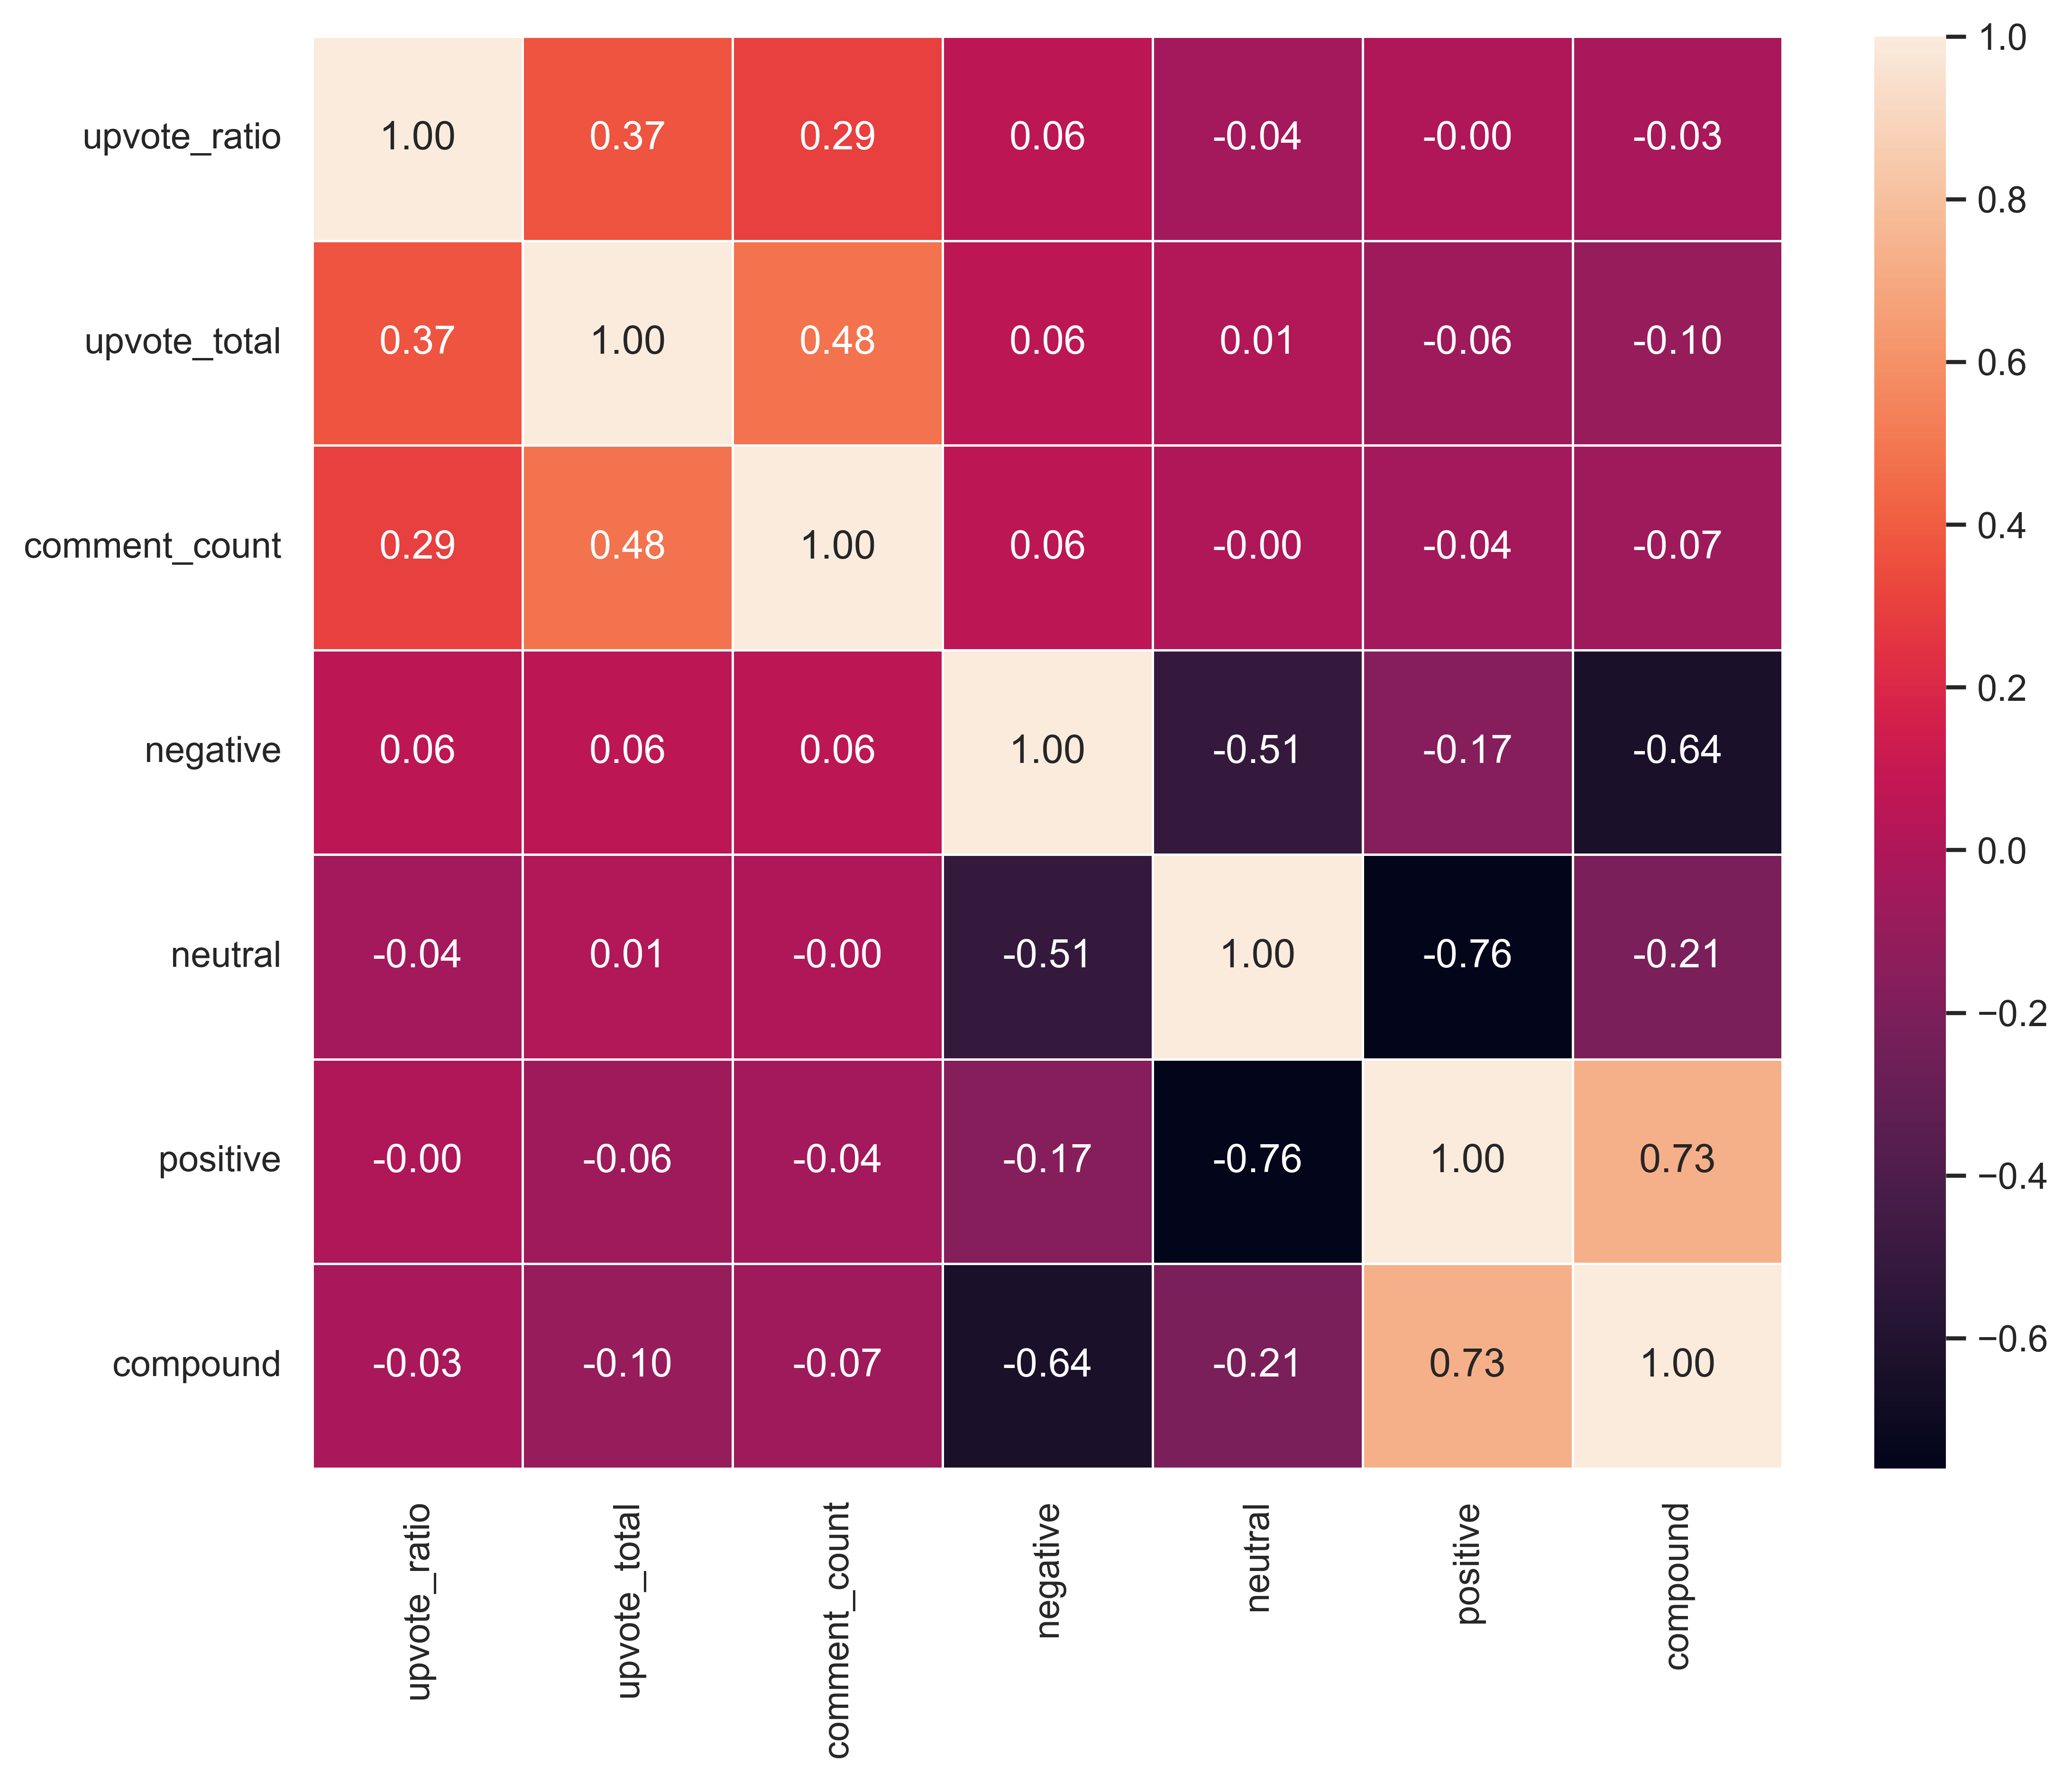

In [46]:
#using seaborn and matplot  we can visulize the above as a heatmap
#imports
import seaborn as sns
import matplotlib.pyplot as plt
#code here
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

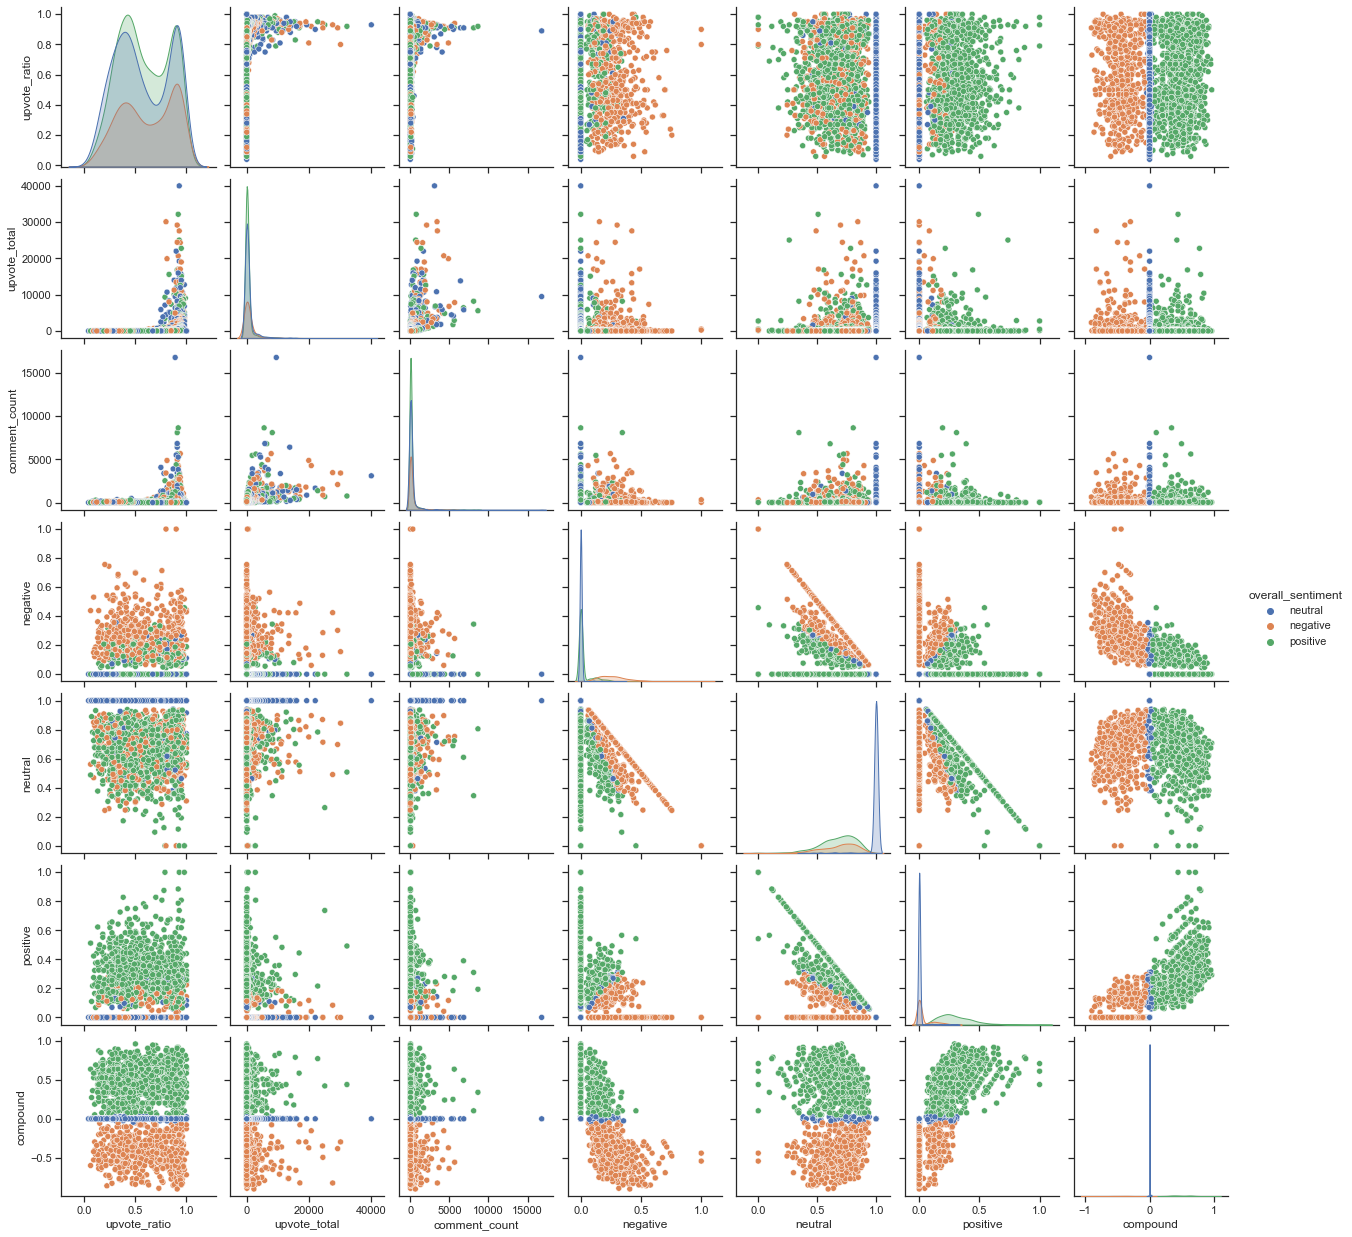

In [47]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="overall_sentiment")

##### Drawing Conclusions from the Current Correlation
 We can see some of the ones with some significant correlation include neutral-negative, neutral-positive, compound-positive, and compound-negative.  **However** for this reasearch this is expected as these are the sentiment values we derive using Vader Sentiment Analysis. We expect the change from positive-neutral-negative and compound to be affected by each other value. So this is not what we are looking for and we can disregard.
 We are interested in specifically in the upvote_ratio, upvote_total, and comment_count's interation with the sentiment scores. From the heat map we can see specifically there is no significant correlation. The only notable value is a .48 between comment_count to upvote_total and .37 between upvote_ratio to upvote_total. Which once again is slighlty expected but not fully supported by the current dataset to be called significant.
 #### Final Conclusion:
 There is **no significant correlation** between the ***sentiment scores*** and the ***upvote_ratio/upvote_total/comment_count***.
 ***

## Binnning
### What's next?
Our conclusion on performing correlation on the entire dataset returns no significant correlation. So what's next? We have a specific column in our dataset that might help. `data_created` attribute can be used to take advantage of the data mining technique know as Binning. We can thus split our data into weekend vs weekday or even by time of day(morning-evening-night). 

In [48]:
#imports
import random
import numpy as np
# Ensure the date_created is a pandas datetime object, if not loaded as such
#df["date_created"] = pd.to_datetime(df["date_created"])
#Check if the time bin column exists, 
if 'time_bin' in df.columns:
    df = df.drop(["time_bin"], axis=1)
    
'''
Based on the time of days as describe in the britiannica dictionary website
https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc

time can be seprated as
Morning 5 am to 12 pm (noon)
Afternoon 12 pm to 5 pm.
Evening 5 pm to 9 pm.
Night 9 pm to 4 am.


for our dataset we have: 
12 am to 6am  -Night
6am to 12pm  -Morning
12pm to 6pm -Afternoon
6pm to 12am - Evening

We will consider our binnings as such.
df_night, df_morning, df_afternoon, df_evening
'''    
    
# define the bins 
bins = [0, 6, 12, 18, 24]

# add custom labels if desired
labels = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']

# add the bins to the dataframe
df['time_bin'] = pd.cut(df.date_created.dt.hour, bins, labels=labels, right=False)

print(df.head(10))


                                        cleaned_post      pid  \
0          Just Got My BRAND NEW game from GameStop!  176i70g   
1  Whats one of the biggest wastes of money in Ga...  176ad4v   
2  Valve adds new security check after attackers ...  1763wf1   
3  I just set the world record for the fastest de...  17aully   
4  I decided to play Star Wars Battlefront 2 (200...  176ixo6   
5                                       Best visuals  176fdcs   
6  MC Chris rants about Kingdom Hearts 2 and Resi...  176c2q1   
7  What game that people talk about “everyone mus...  176dzxe   
8  What went wrong with Sonic that it couldnt hol...  17aylsr   
9  This comment made on the Alan Wake/Fornite cro...  17au67y   

                 author        date_created  upvote_ratio  upvote_total  \
0        brandonbluntly 2023-10-12 17:35:09          0.90         11512   
1         TheLuiginator 2023-10-12 11:58:39          0.92         10815   
2       ultimatemanan97 2023-10-12 06:40:14          0.97  


---
## Slicing
### Creating smaller datasets
After binning our data, we can then slice the original dataset into smaller datasets each within a different time of the day. With this we can peform our Pearson correlation.

In [49]:
#Perform slicing
df_night = df[df["time_bin"].isin(["00:00-05:59"])]
df_morning = df[df["time_bin"].isin(["06:00-11:59"])]
df_afternoon = df[df["time_bin"].isin(["12:00-17:59"])]
df_evening = df[df["time_bin"].isin(["18:00-23:59"])]

#Show the lengths of each
print(
"Length of df_night:",len(df_night),
"\nLength of df_morning:",len(df_morning),
"\nLength of df_afternoon:", len(df_afternoon),
"\nLength of df_evening:",len(df_evening)
)

Length of df_night: 439 
Length of df_morning: 740 
Length of df_afternoon: 993 
Length of df_evening: 661


In [50]:
#Perform correlation on each dataset
corr_night = df_night.corr(method = 'pearson')
corr_morning = df_morning.corr(method = 'pearson')
corr_afternoon = df_afternoon.corr(method = 'pearson')
corr_evening = df_evening.corr(method = 'pearson')

## Heat maps
---

### Night

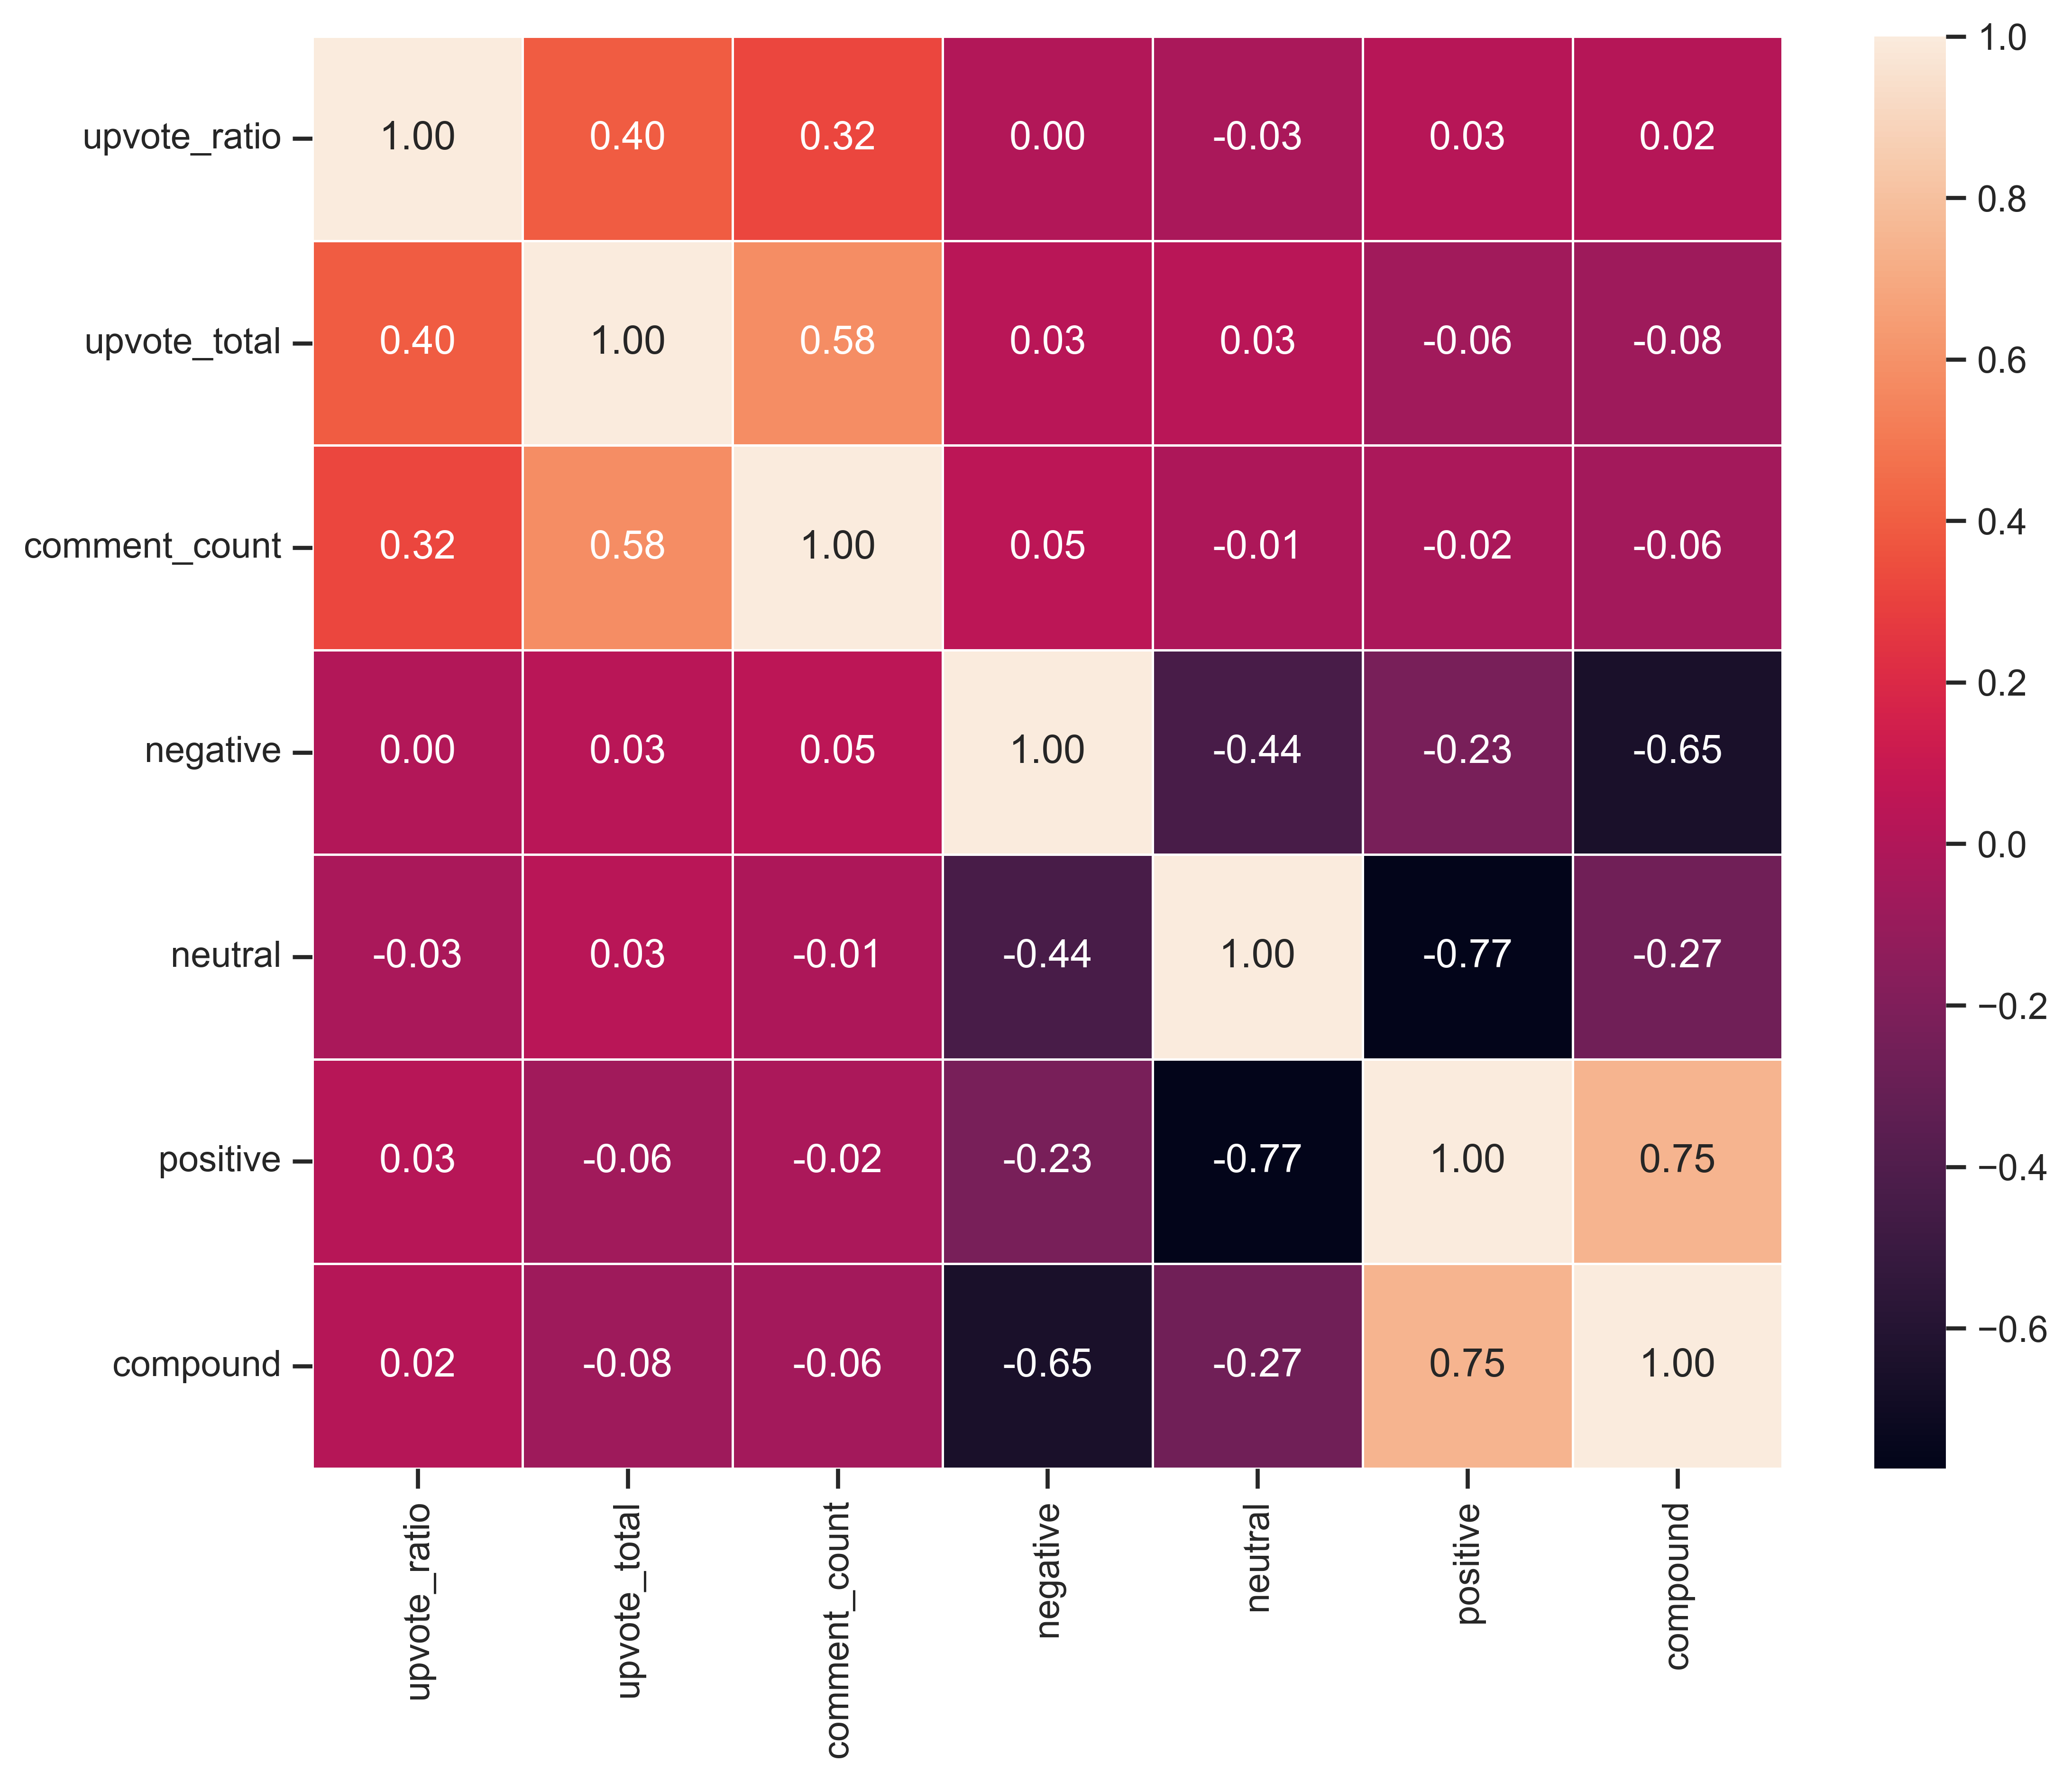

In [51]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr_night,annot=True,fmt=".2f", linewidth=.5)
plt.show()

### Morning

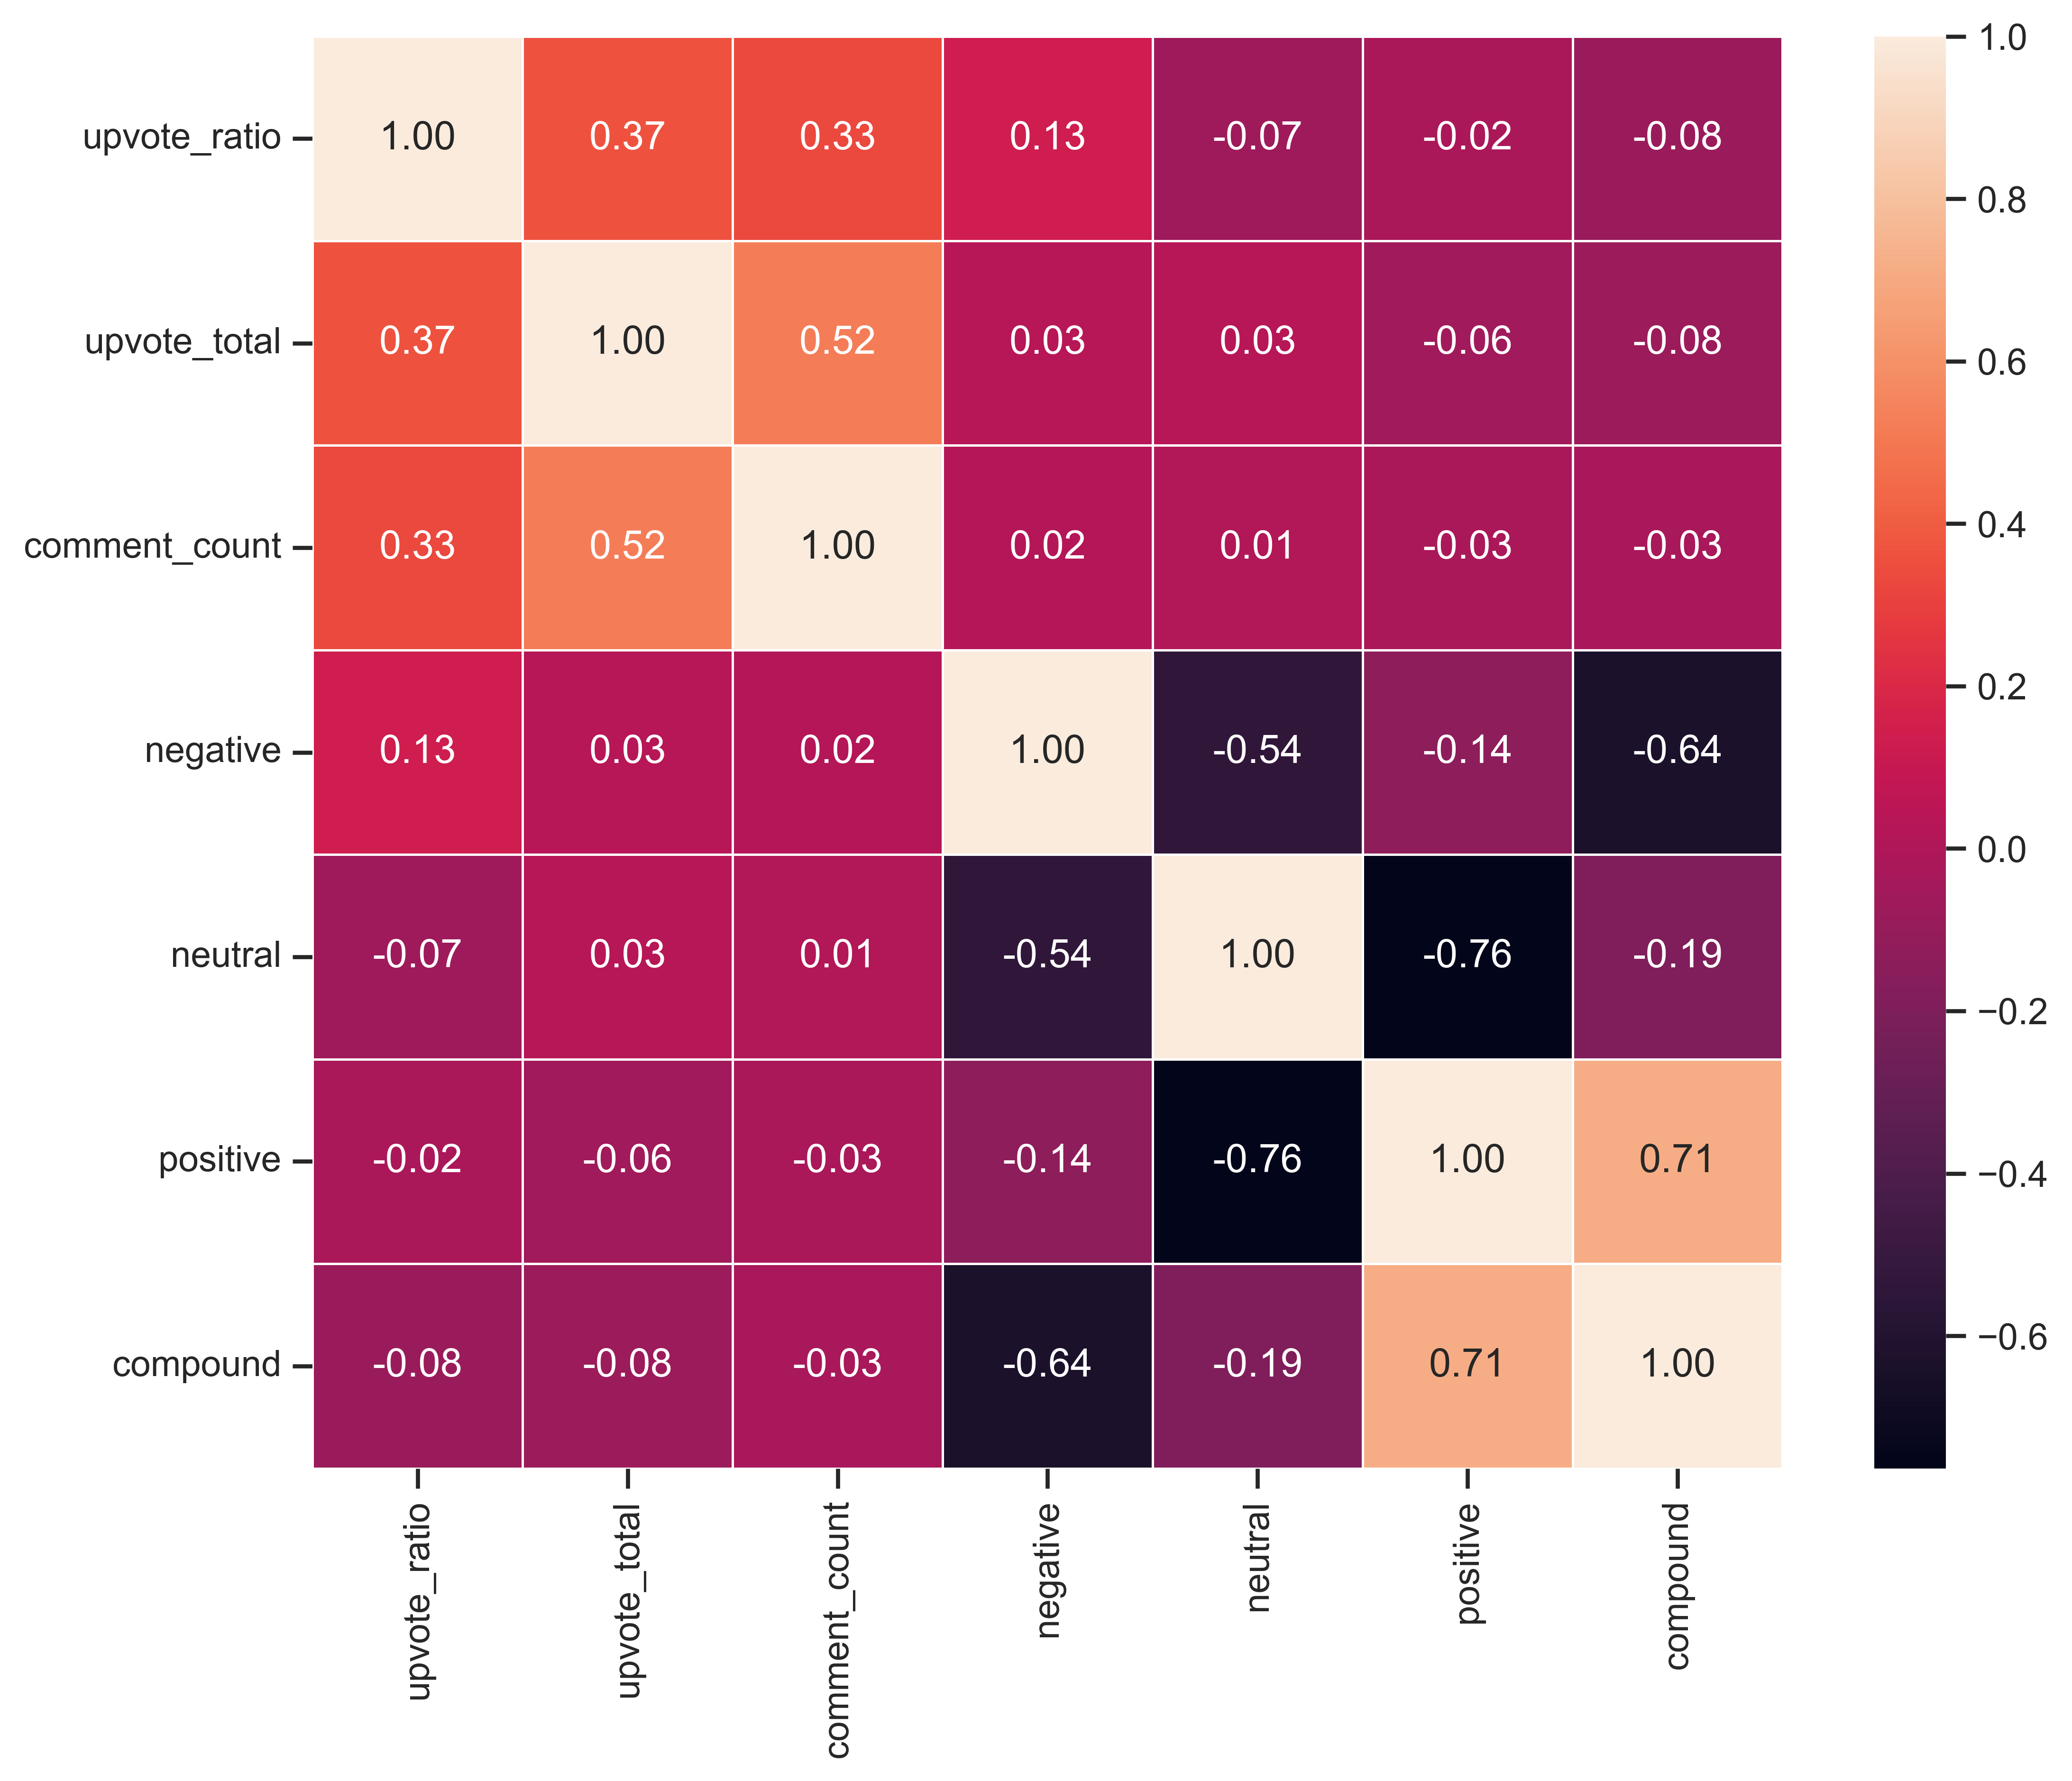

In [52]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr_morning,annot=True,fmt=".2f", linewidth=.5)
plt.show()

### Afternoon

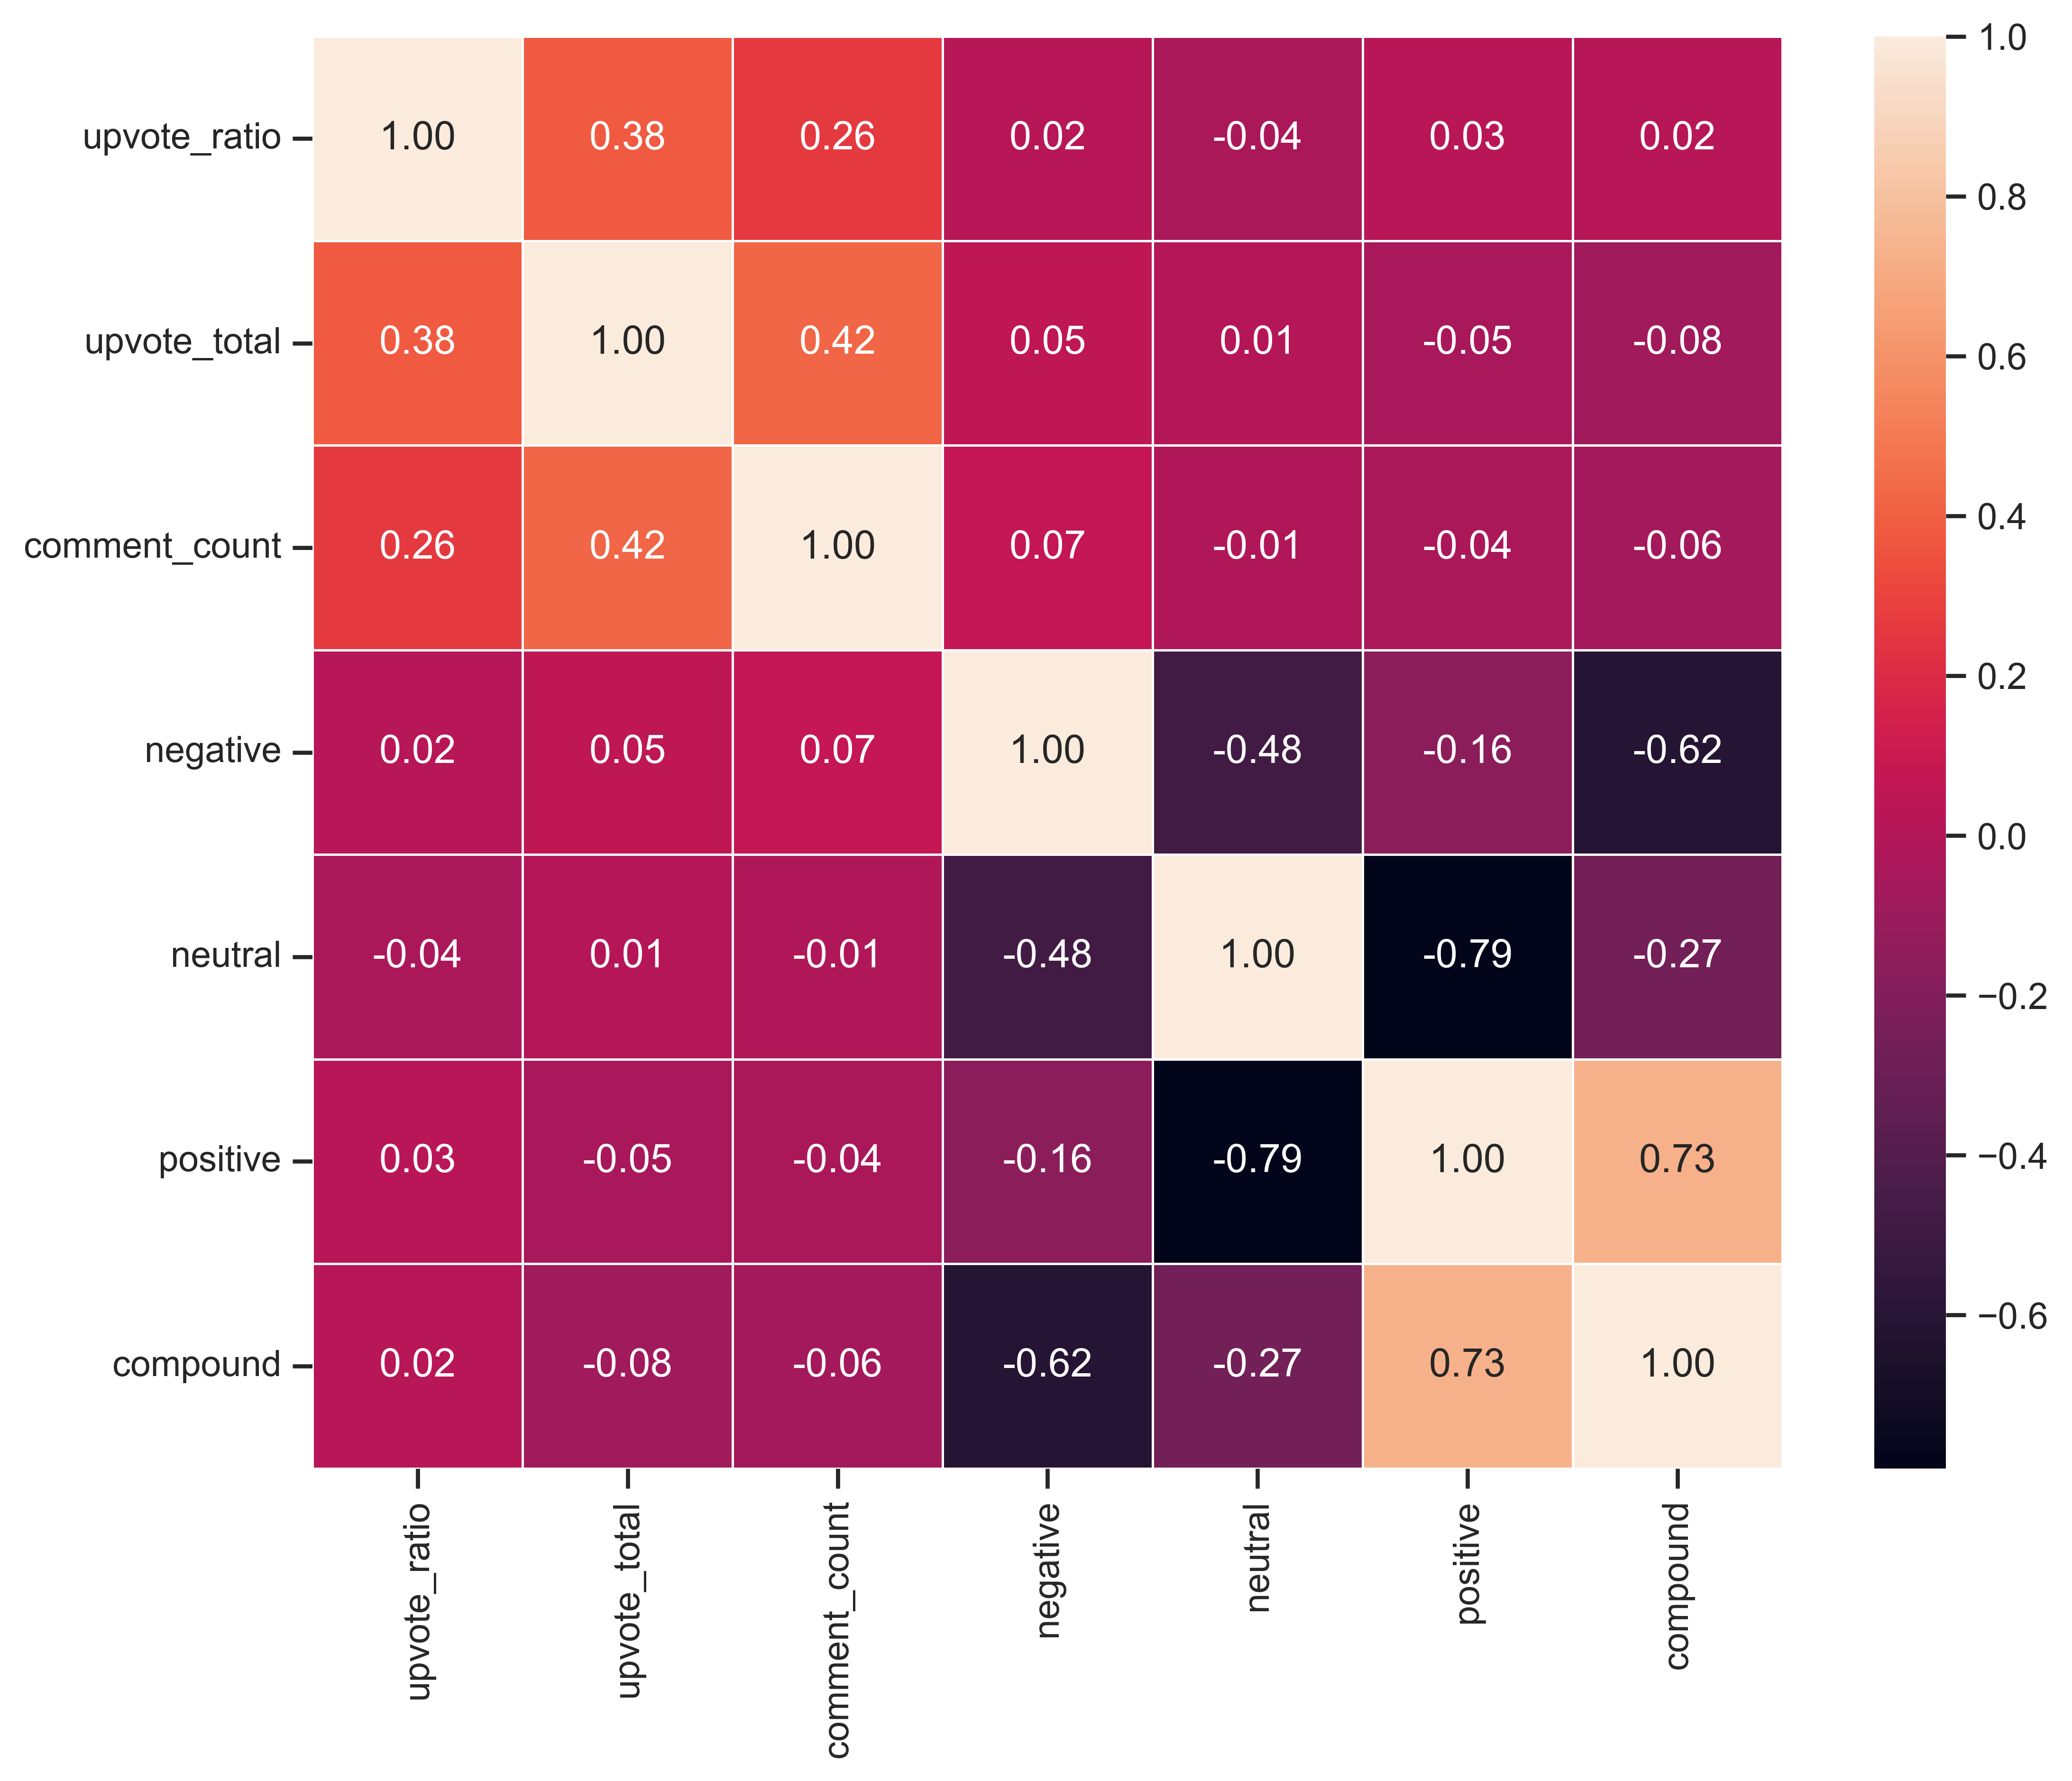

In [53]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr_afternoon,annot=True,fmt=".2f", linewidth=.5)
plt.show()

### Evening

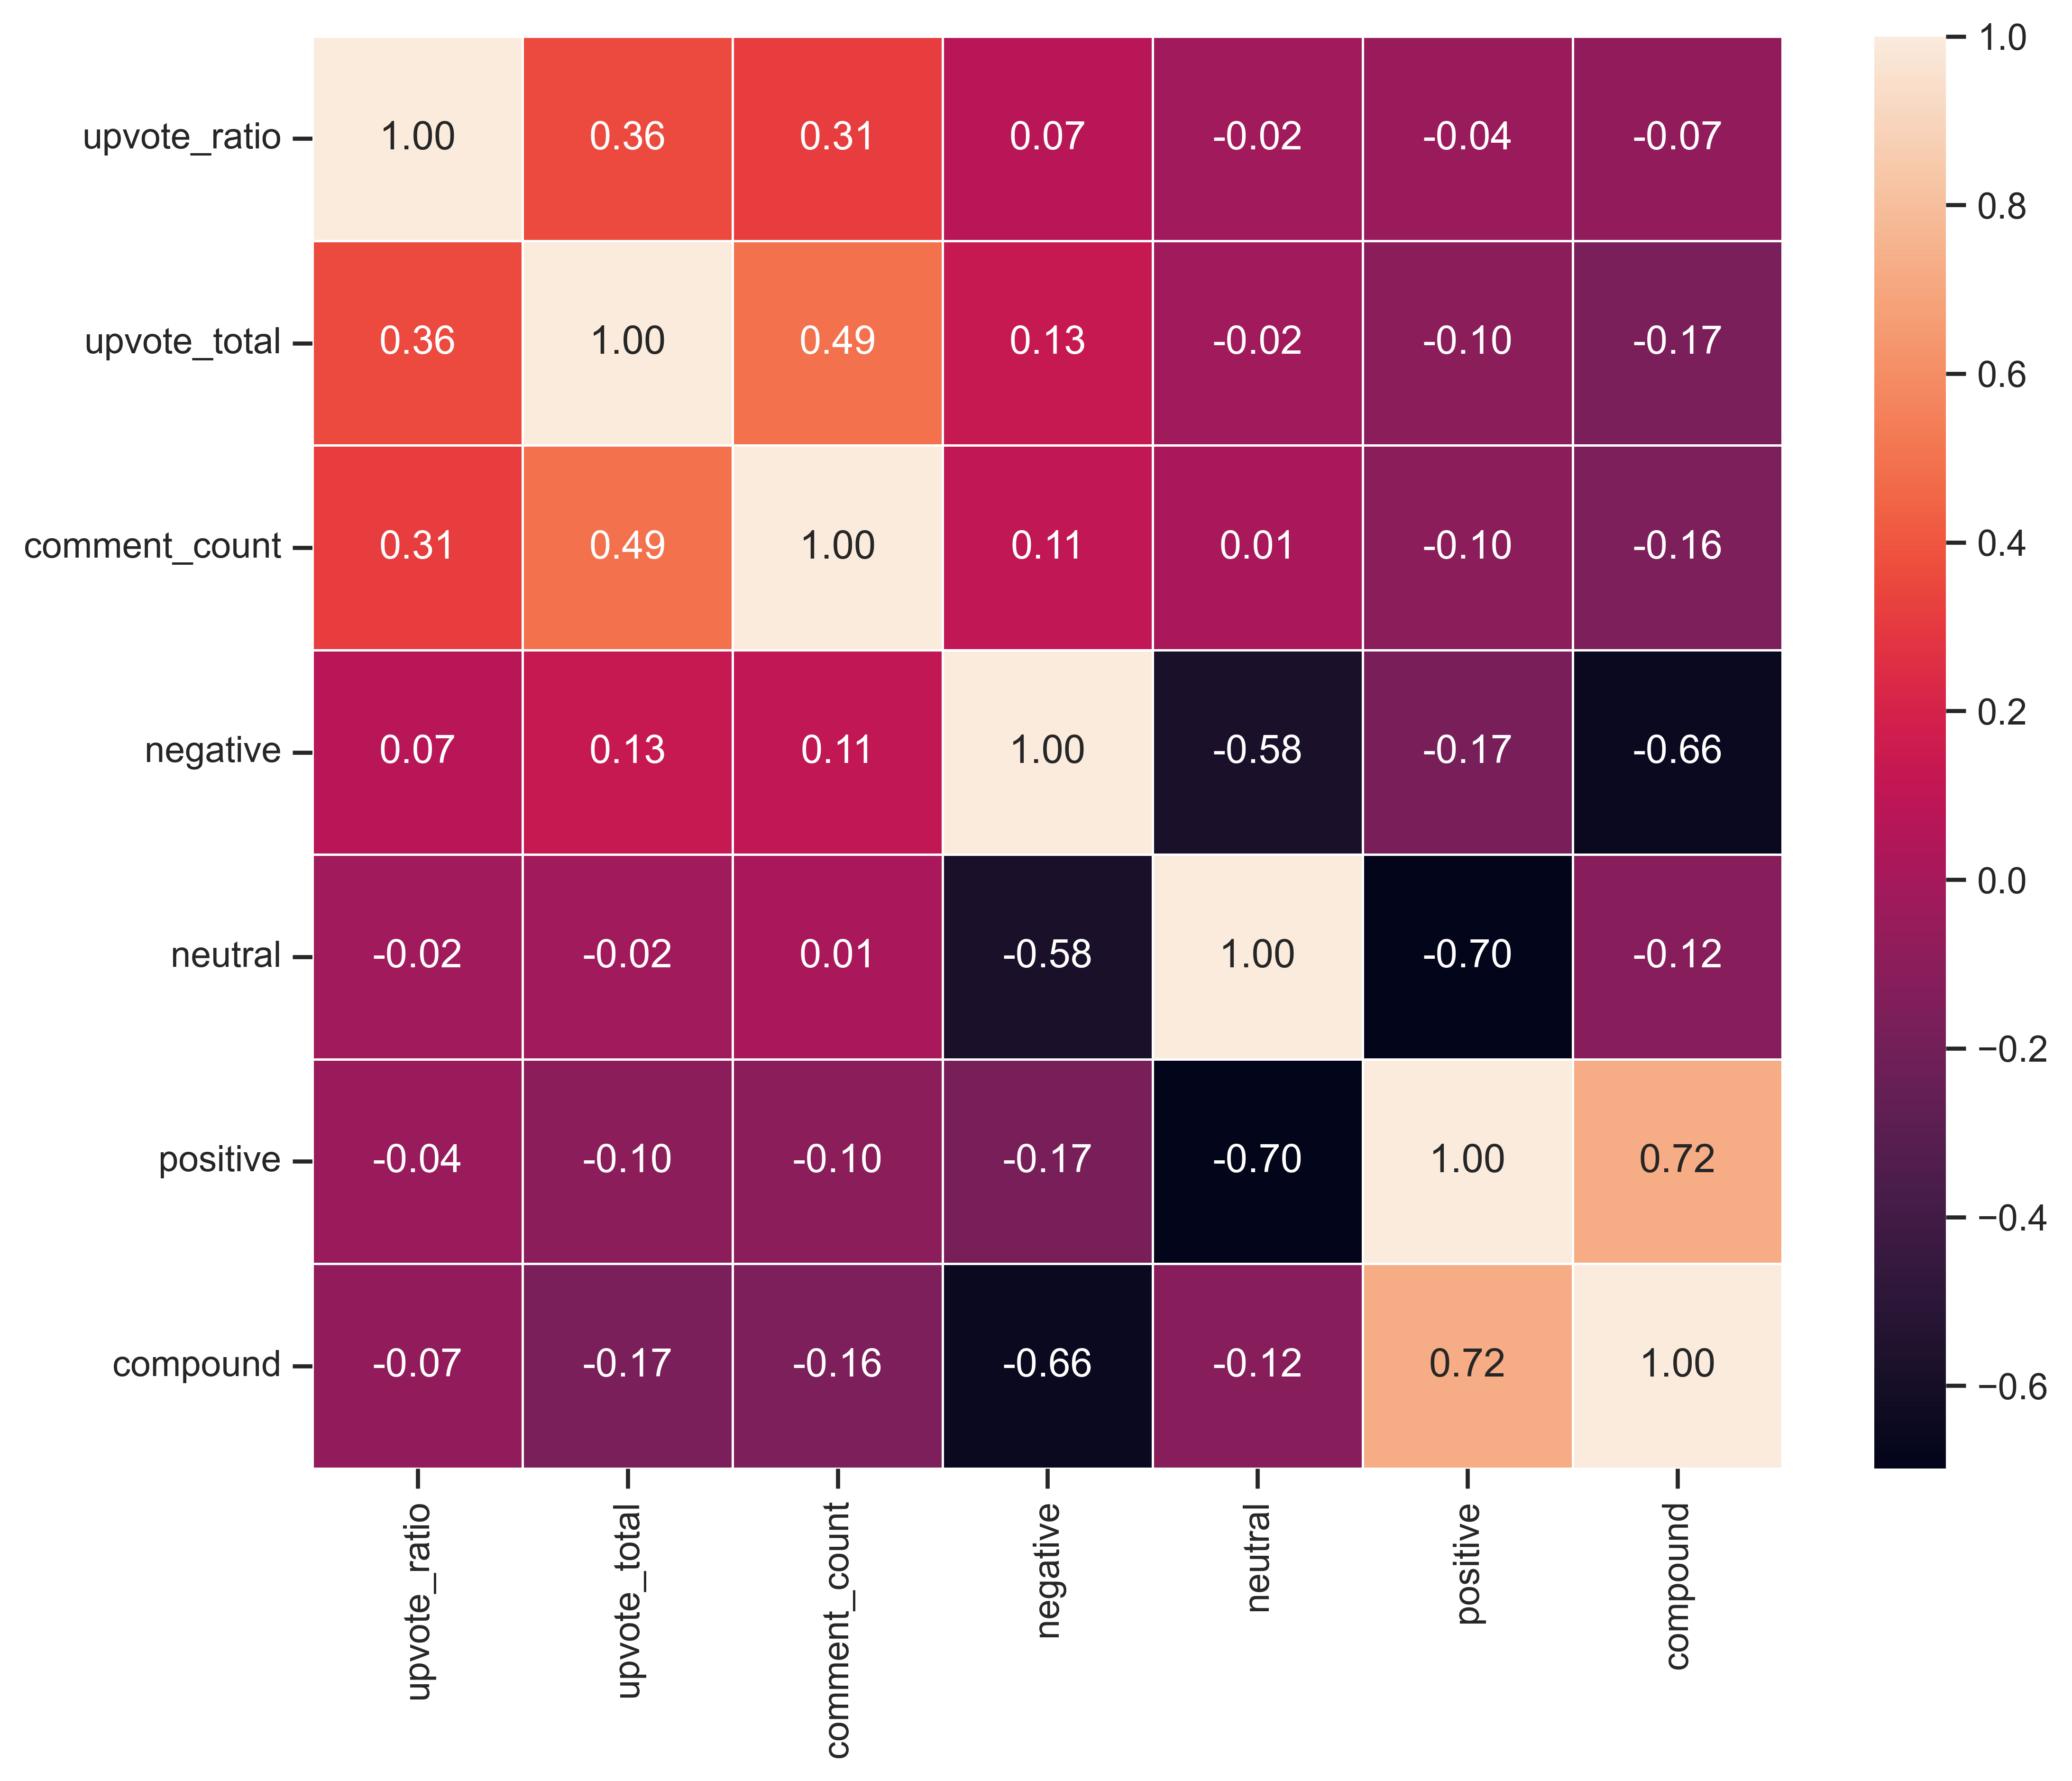

In [54]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(corr_evening,annot=True,fmt=".2f", linewidth=.5)
plt.show()

## Binning Conclusion 
Based of the binning the dataset, we notice once again that there is no significant correlation between the title's positivity/negativity/neutrality and the upvote_ration/upvote_total/comment_count. 
One important note however is that post during the evening, do see a slight uptick between negative/positive to upvote total & comment count. This may be a lead to possible correlation with posts created during the evening but it would require further reasearch and a greater dataset. But again it is not significant enough to claim correlation between sentiment and the post's upvotes/comments.
In conclusion, there seems to be no correlation between the sentiment of a Post's title and the comment/upvote totals.




---

# Time Series
## Applying the data as a time series


In [72]:
# print(df.date_created.dt.date)
df_timeseries = df.groupby(df.date_created.dt.date).mean()
df_timeseries.head(10)

upvote_ratio  upvote_total  comment_count  negative   neutral  \
date_created                                                                  
2023-10-11        0.462857    106.714286     190.857143  0.106000  0.840000   
2023-10-12        0.586271    906.864407     285.271186  0.087322  0.771458   
2023-10-13        0.590000   1000.430556     266.972222  0.086319  0.775375   
2023-10-14        0.567945    548.561644     225.342466  0.070822  0.776781   
2023-10-15        0.588158    666.723684     194.855263  0.071724  0.782368   
2023-10-16        0.635735   1061.455882     322.500000  0.052588  0.835426   
2023-10-17        0.622571   1167.714286     271.371429  0.057814  0.843743   
2023-10-18        0.612159    835.375000     222.340909  0.085295  0.770705   
2023-10-19        0.601800    715.400000     247.730000  0.065310  0.804720   
2023-10-20        0.545042    655.310924      99.798319  0.056639  0.792681   

              positive  compound  
date_created                      
2023-10-11    0.054000 -0.076571  
2023-10-12    0.141254  0.106356  
2023-10-13    0.138347  0.095972  
2023-10-14    0.152370  0.151685  
2023-10-15    0.145895  0.123461  
2023-10-16    0.112044  0.106779  
2023-10-17    0.098457  0.074114  
2023-10-18    0.144000  0.082375  
2023-10-19    0.129990  0.105710  
2023-10-20    0.150689  0.136353

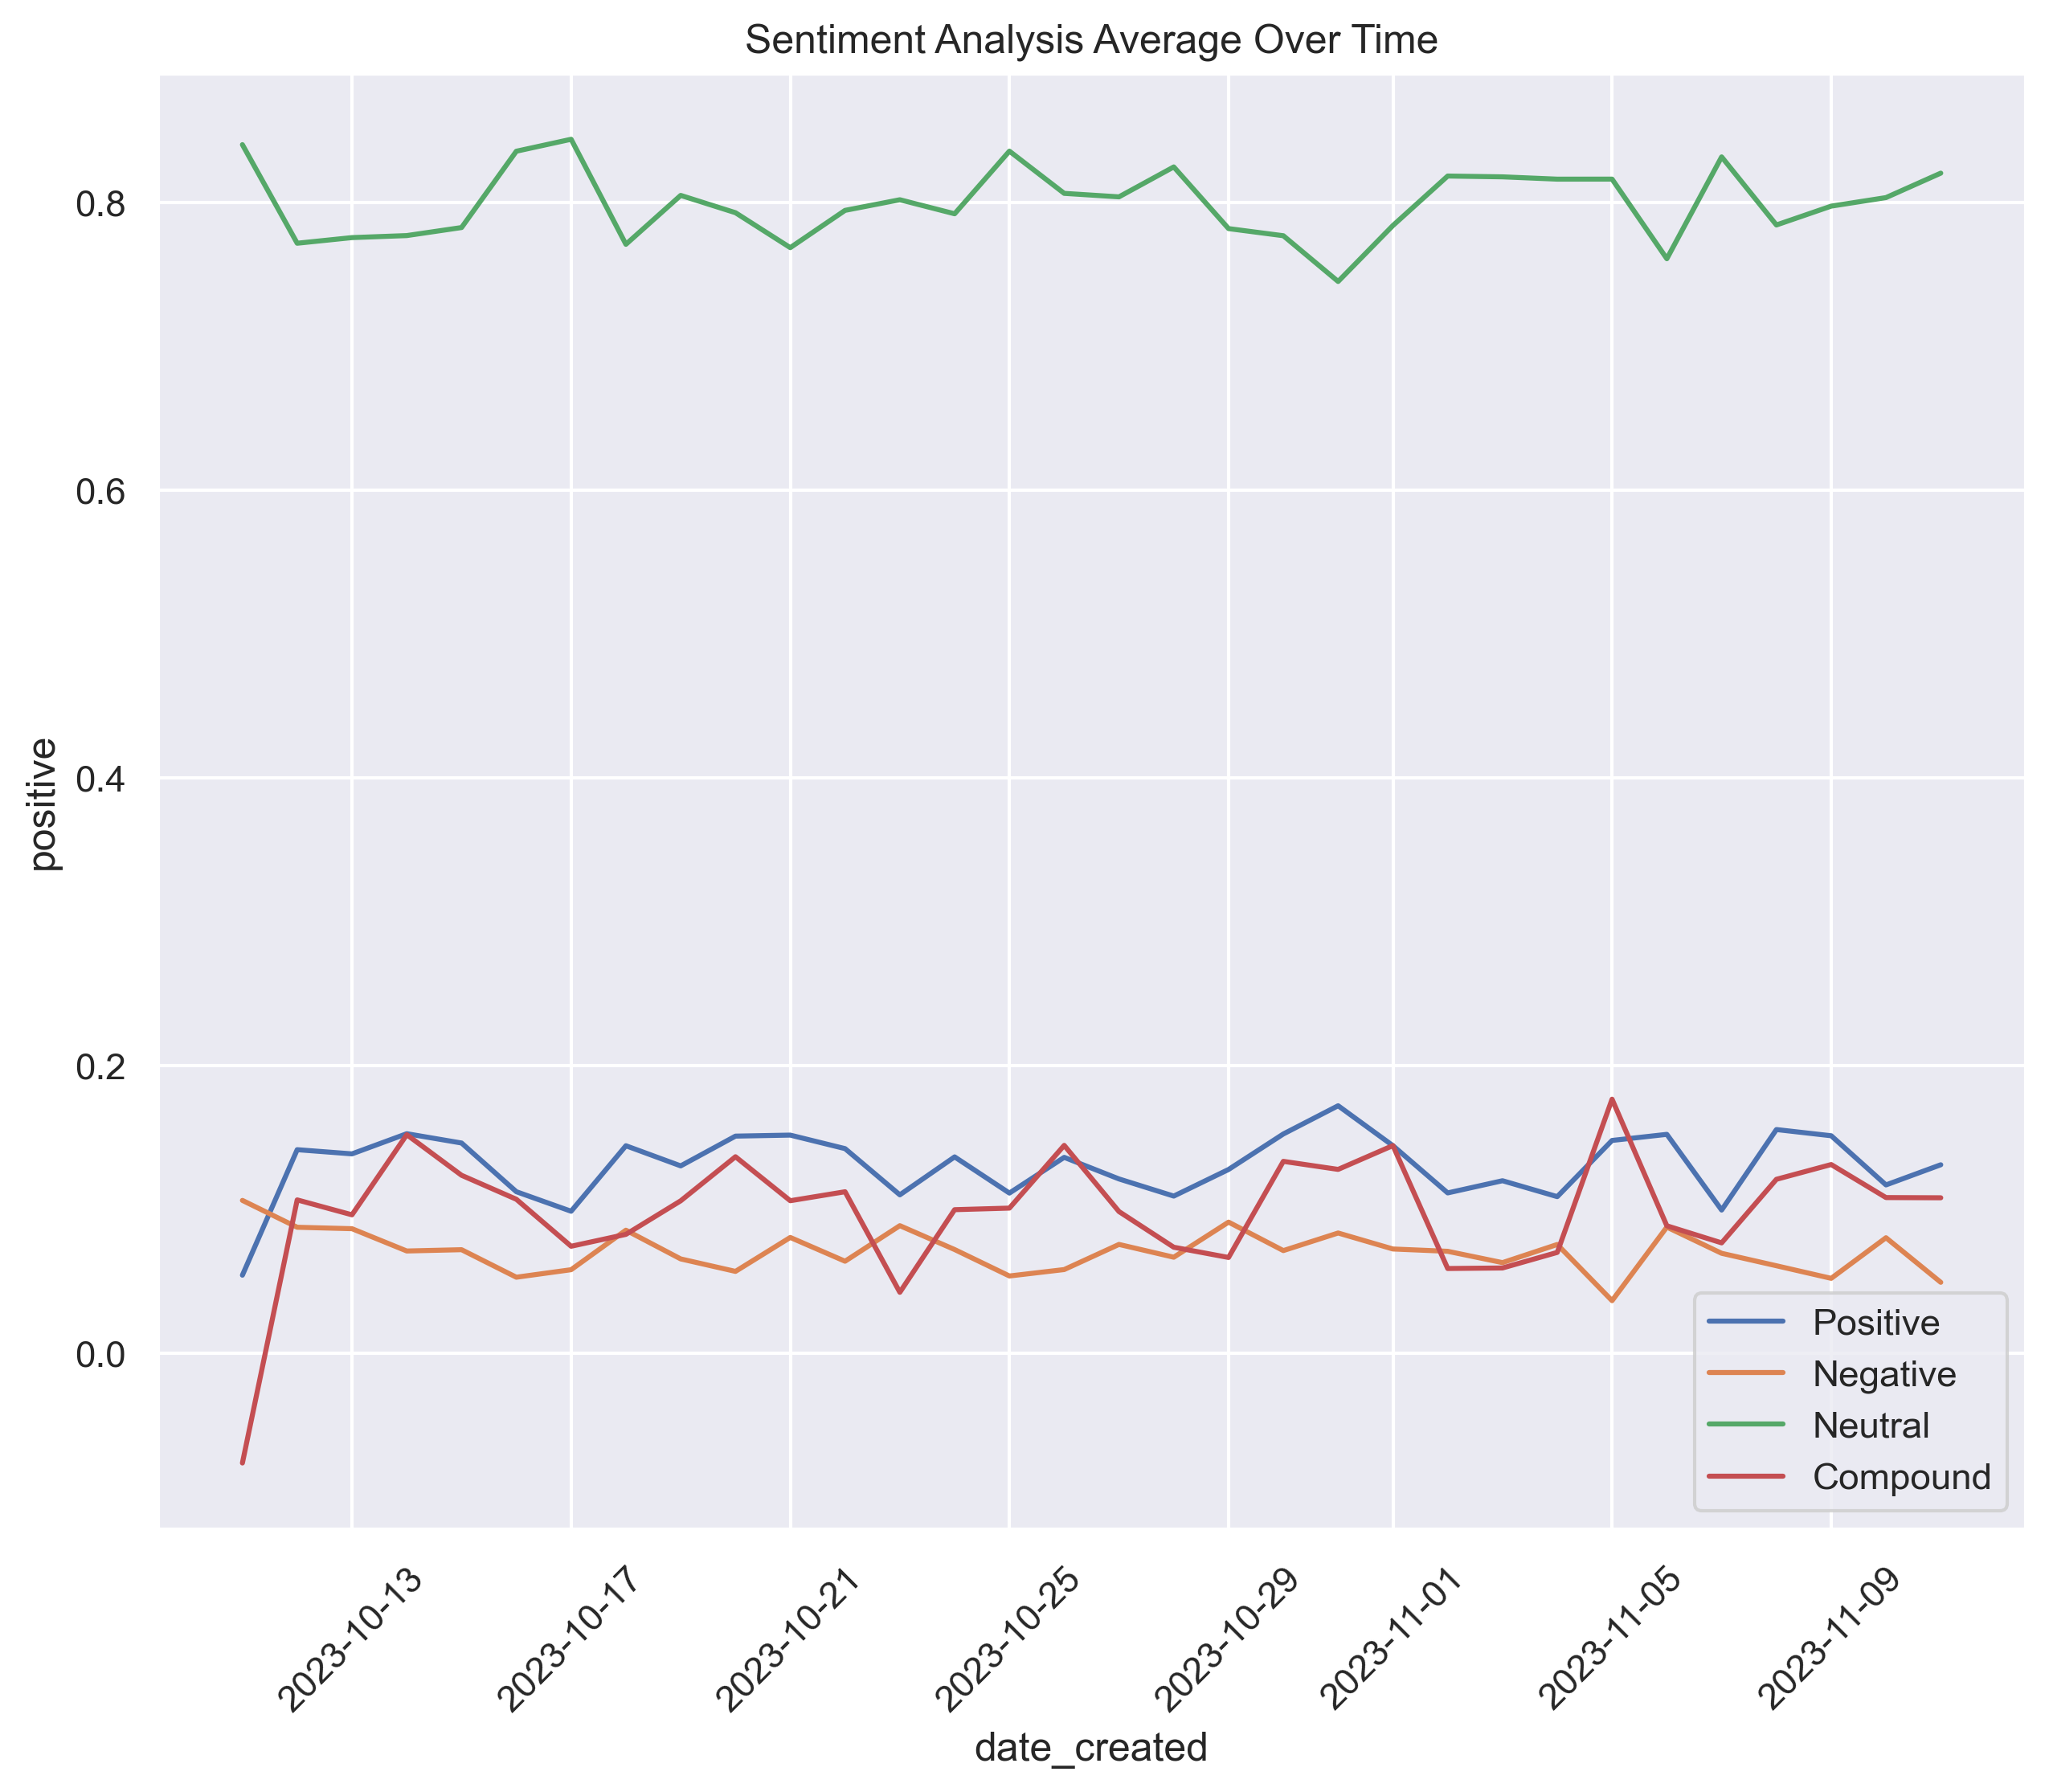

In [82]:
plt.figure(figsize=(10,8), dpi =300)
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="date_created", y="positive", label="Positive",
             data=df_timeseries)
sns.lineplot(x="date_created", y="negative",label="Negative",
             data=df_timeseries)
sns.lineplot(x="date_created", y="neutral",label="Neutral",
            data=df_timeseries)
sns.lineplot(x="date_created", y="compound",label="Compound",
             data=df_timeseries)
plt.xticks(rotation=45)

plt.legend()
plt.title("Sentiment Analysis Average Over Time")
plt.show()

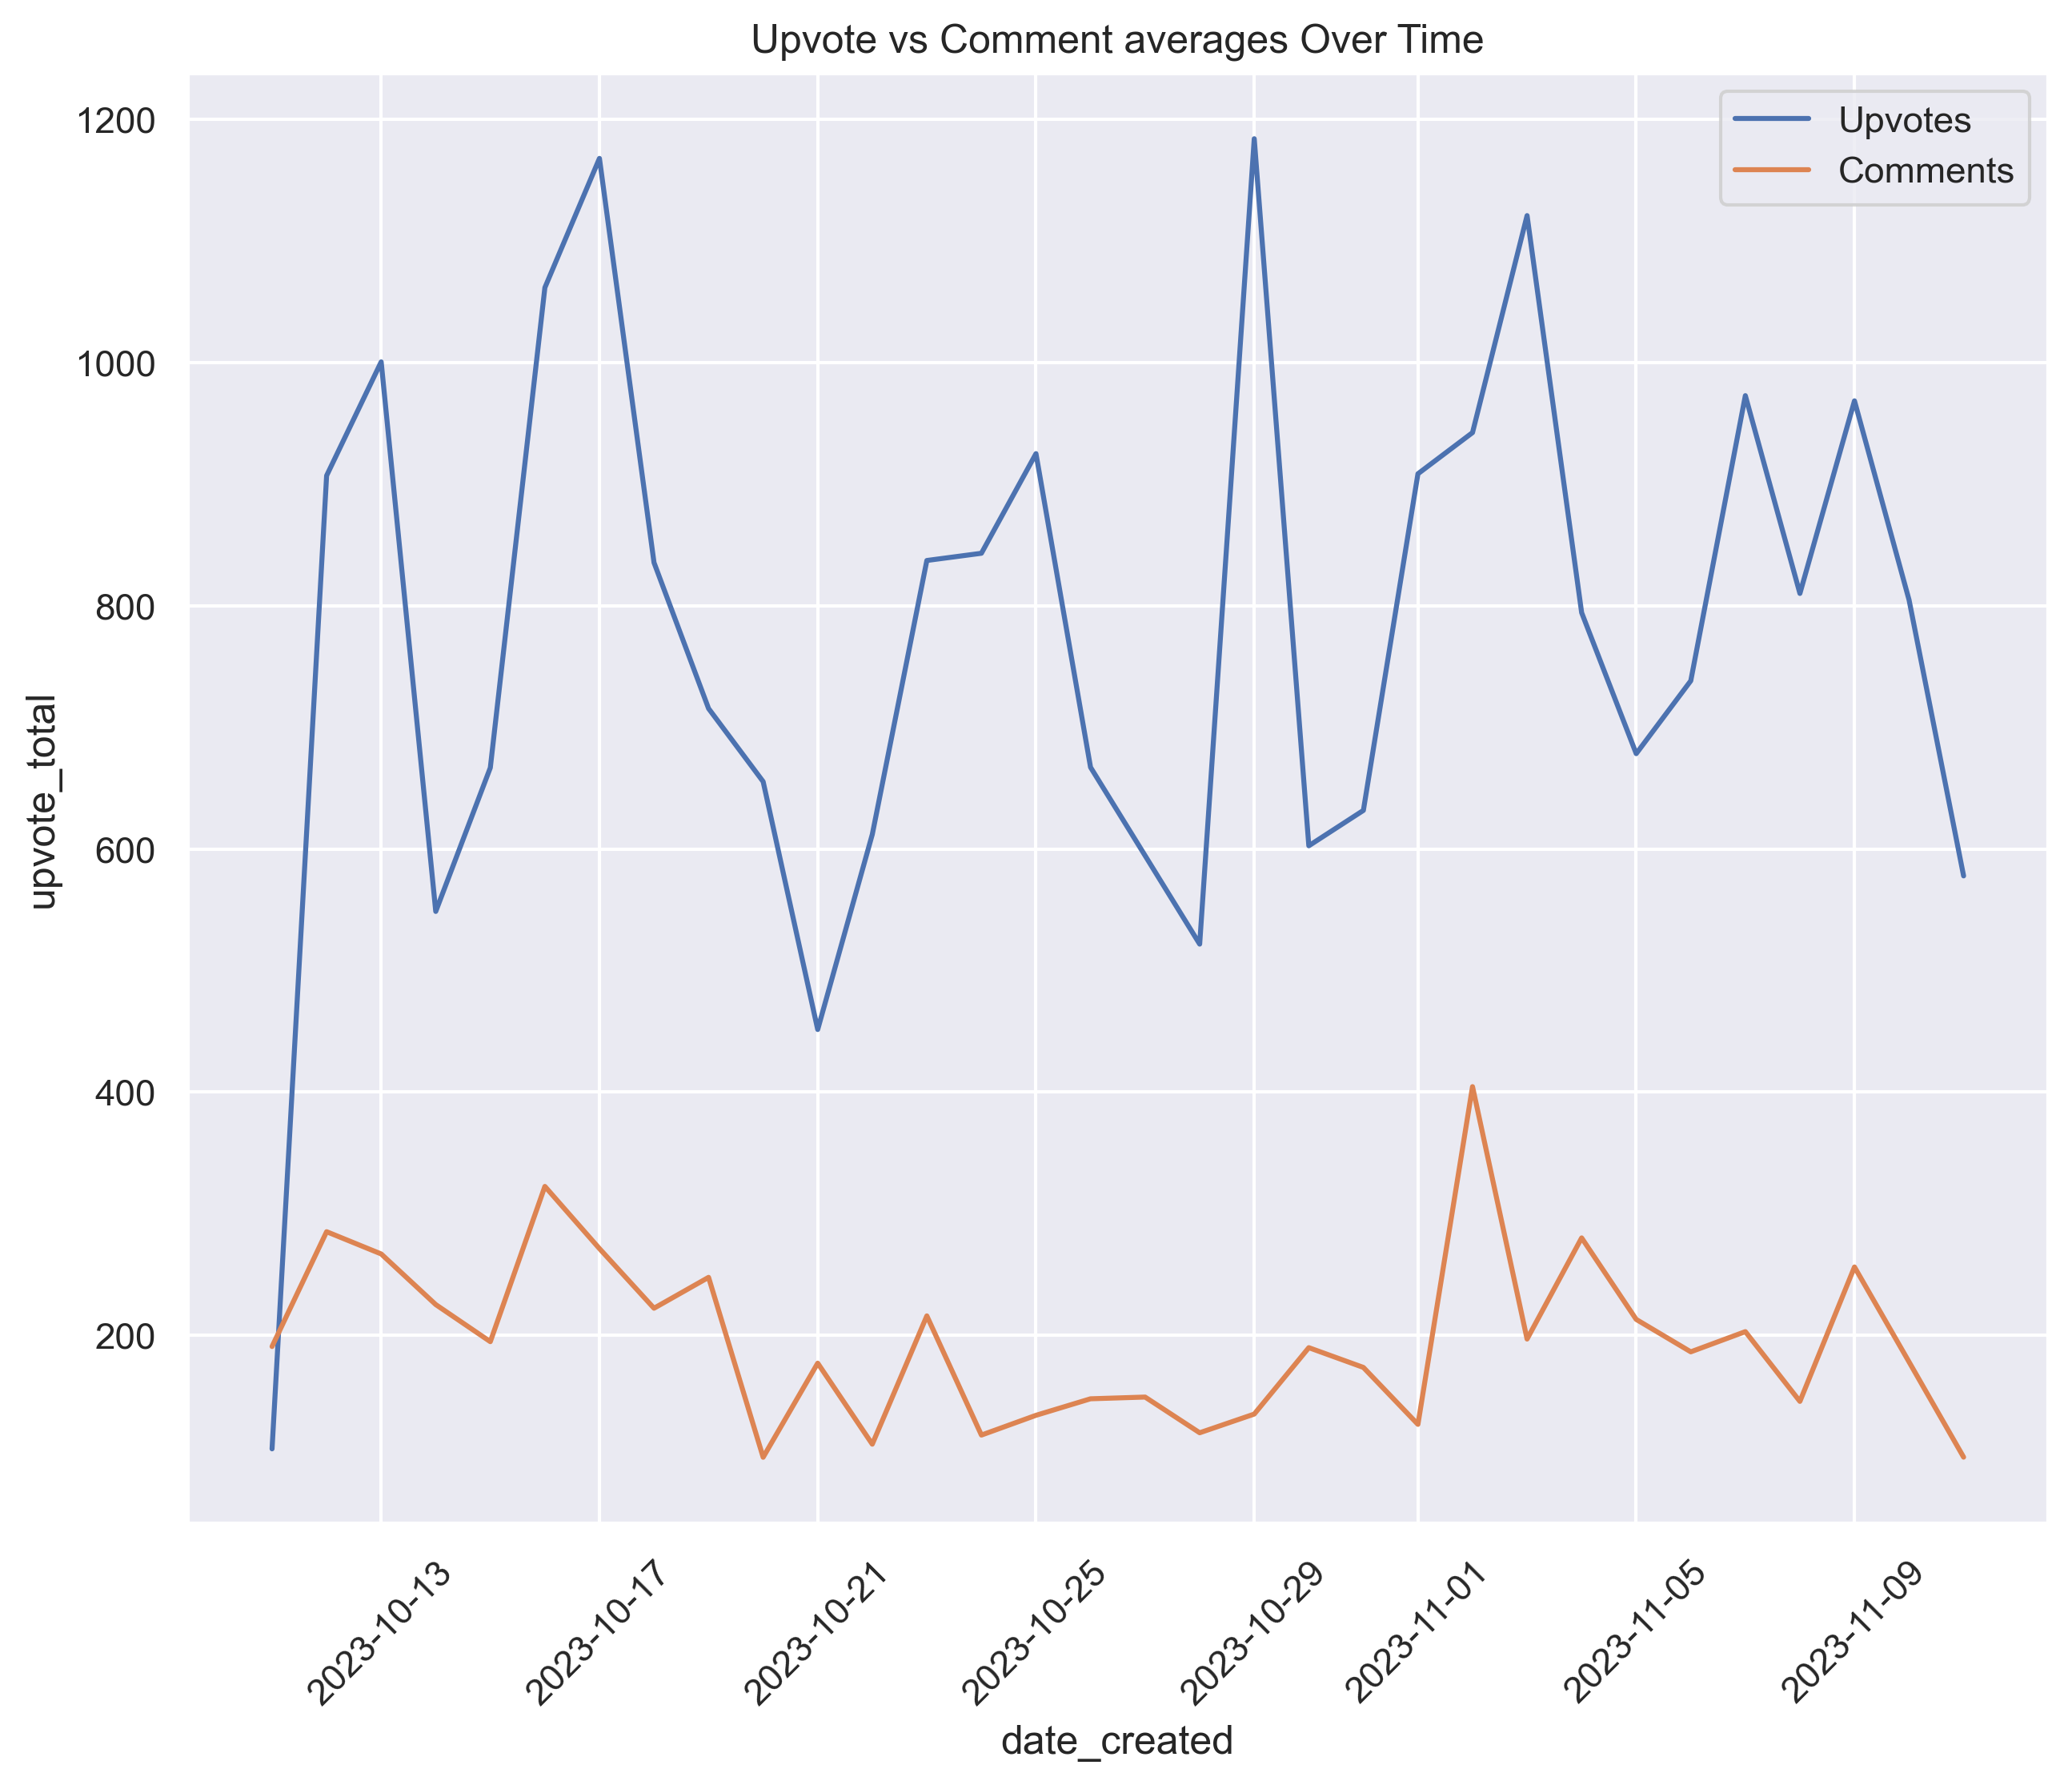

In [86]:
plt.figure(figsize=(10,8), dpi =300)
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="date_created", y="upvote_total",label="Upvotes",
             data=df_timeseries)
sns.lineplot(x="date_created", y="comment_count", label="Comments",
             data=df_timeseries)


plt.xticks(rotation=45)

plt.legend()
plt.title("Upvote vs Comment averages Over Time")
plt.show()

In [80]:
# print(df.date_created.dt.date)
df_timeseries2 = df.groupby(df.date_created.dt.date).sum()
df_timeseries2.head(10)

upvote_ratio  upvote_total  comment_count  negative  neutral  \
date_created                                                                 
2023-10-11            3.24           747           1336     0.742    5.880   
2023-10-12           34.59         53505          16831     5.152   45.516   
2023-10-13           42.48         72031          19222     6.215   55.827   
2023-10-14           41.46         40045          16450     5.170   56.705   
2023-10-15           44.70         50671          14809     5.451   59.460   
2023-10-16           43.23         72179          21930     3.576   56.809   
2023-10-17           43.58         81740          18996     4.047   59.062   
2023-10-18           53.87         73513          19566     7.506   67.822   
2023-10-19           60.18         71540          24773     6.531   80.472   
2023-10-20           64.86         77982          11876     6.740   94.329   

              positive  compound  
date_created                      
2023-10-11       0.378    -0.536  
2023-10-12       8.334     6.275  
2023-10-13       9.961     6.910  
2023-10-14      11.123    11.073  
2023-10-15      11.088     9.383  
2023-10-16       7.619     7.261  
2023-10-17       6.892     5.188  
2023-10-18      12.672     7.249  
2023-10-19      12.999    10.571  
2023-10-20      17.932    16.226

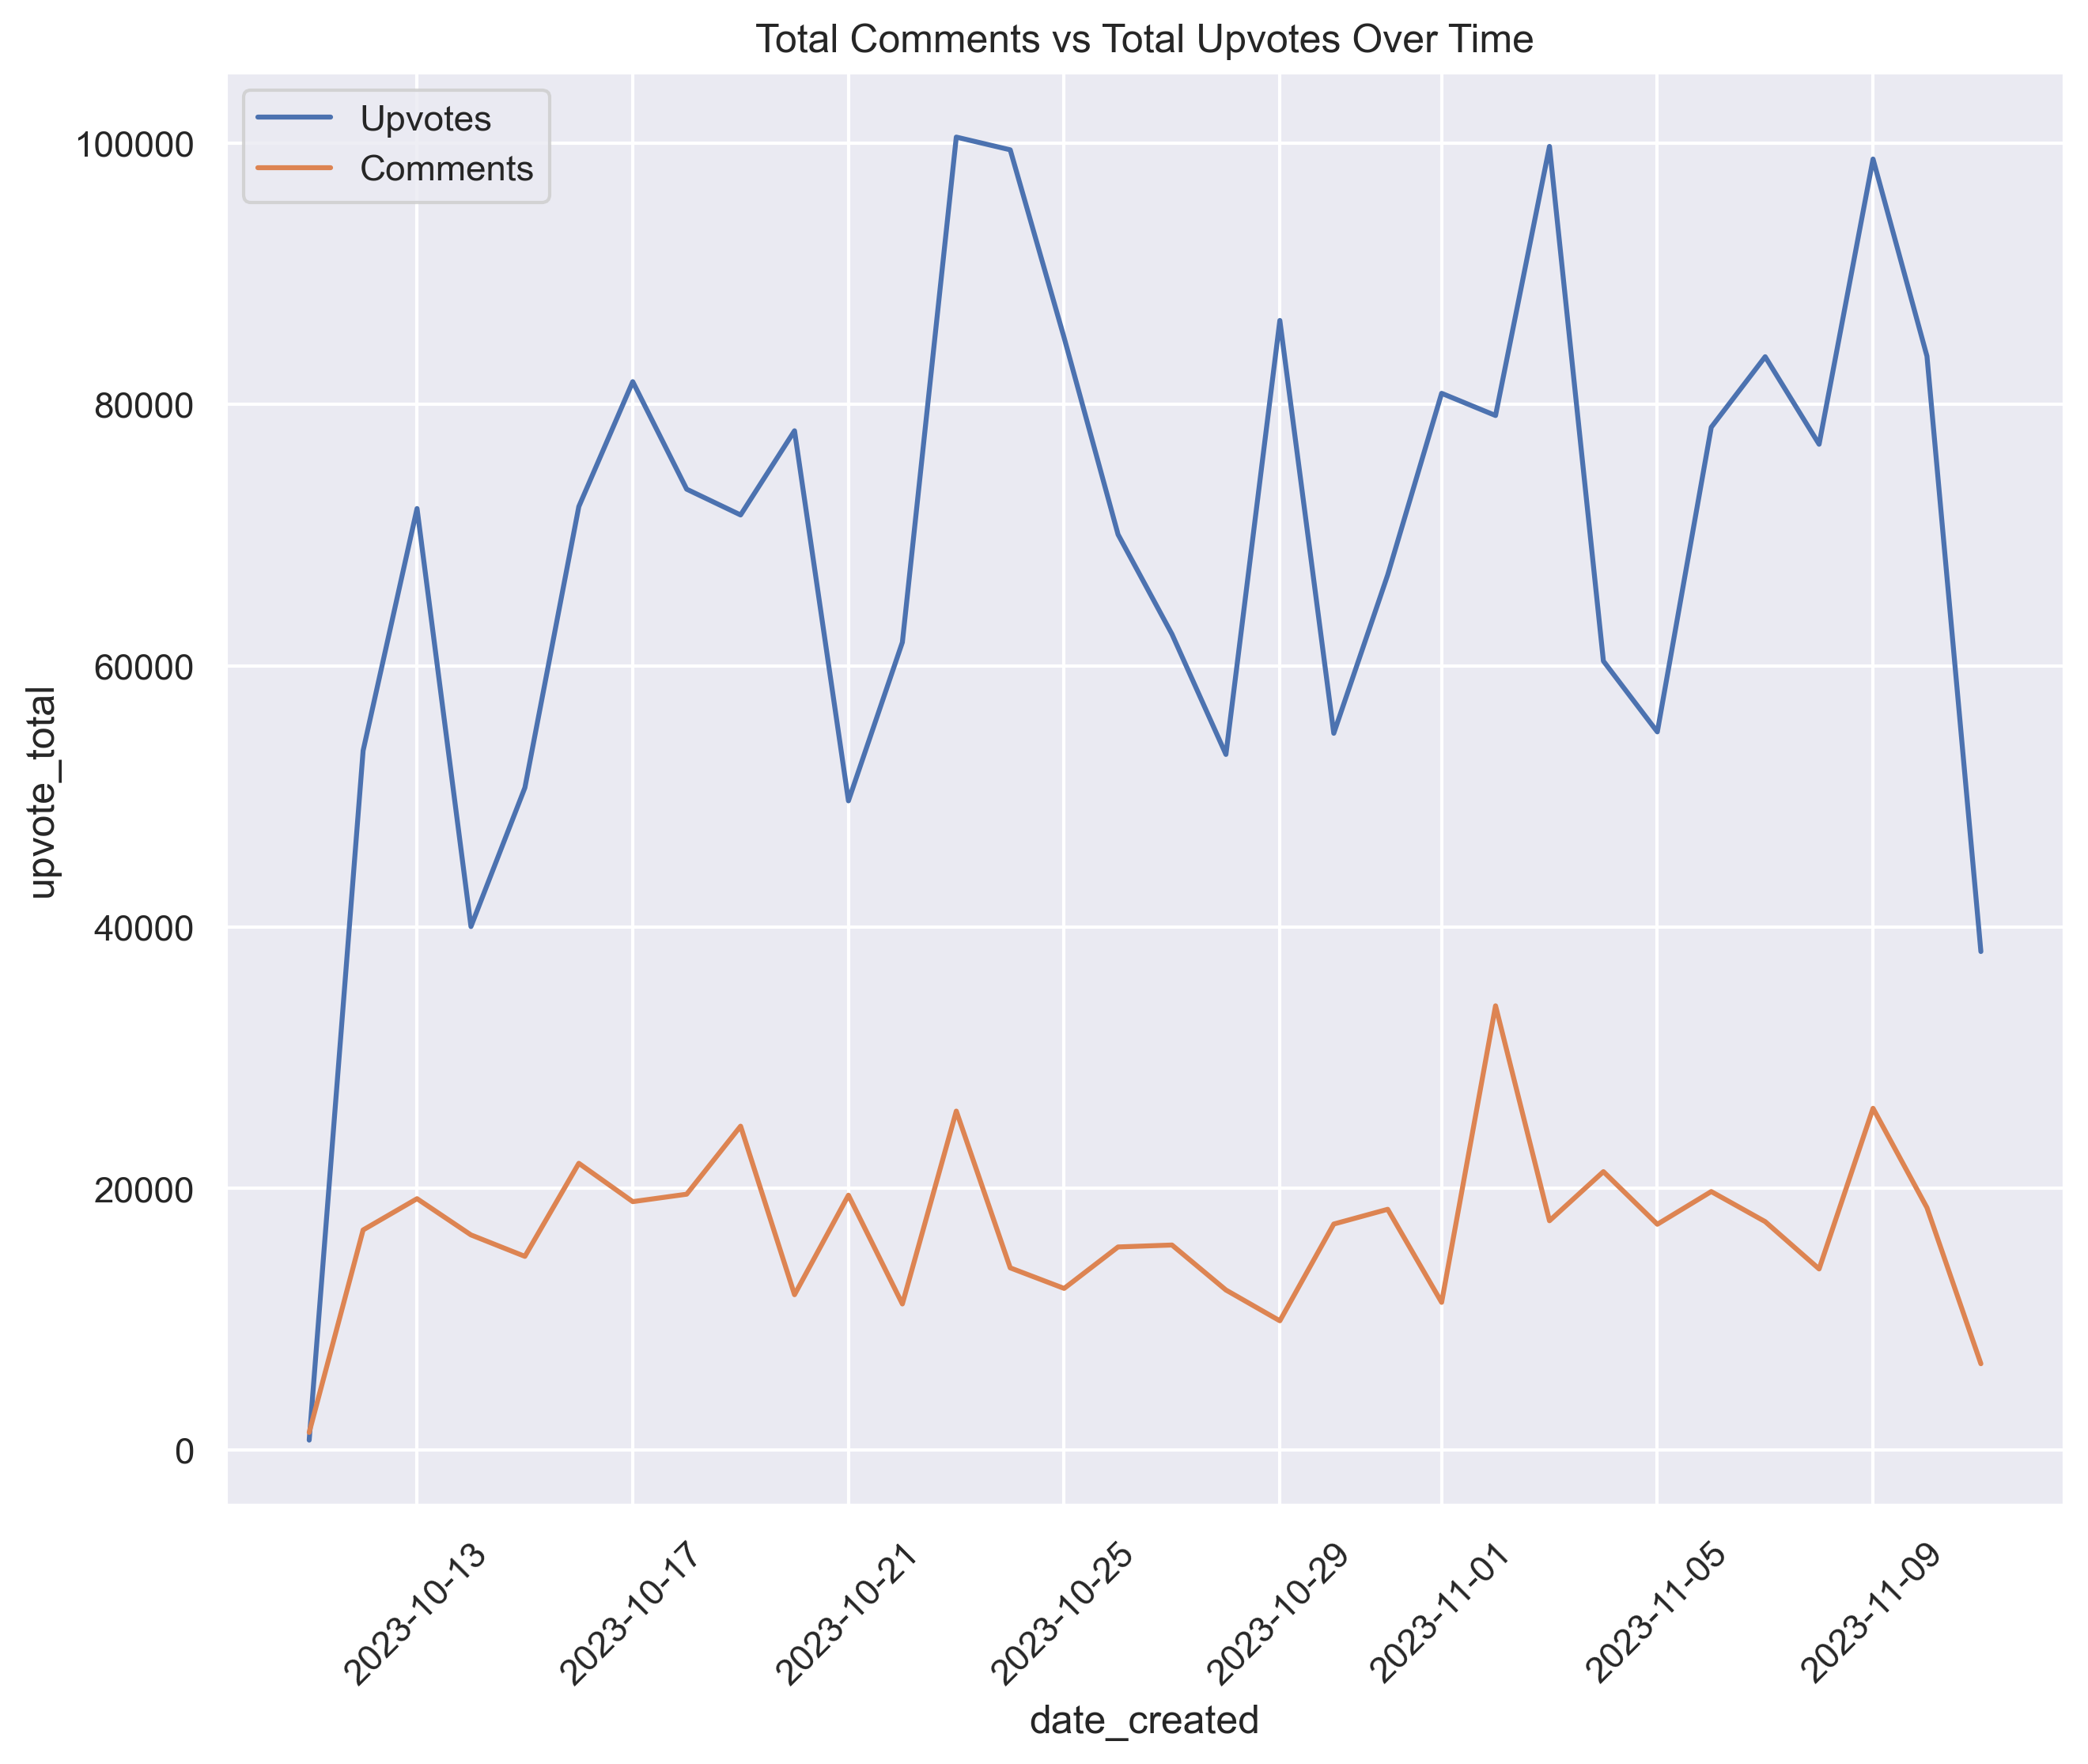

In [87]:
plt.figure(figsize=(10,8), dpi =300)
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
sns.lineplot(x="date_created", y="upvote_total",label="Upvotes",
             data=df_timeseries2)
sns.lineplot(x="date_created", y="comment_count", label="Comments",
             data=df_timeseries2)


plt.xticks(rotation=45)

plt.legend()
plt.title("Total Comments vs Total Upvotes Over Time")
plt.show()